# Проект: Обучение с учителем: качество модели

## Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 

Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import phik

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Загрузка данных

In [2]:
def read_csv_data(main_url, spare_url, sep=";"):
    try:
        return pd.read_csv(main_url, sep=sep)
    except:
        return pd.read_csv(spare_url, sep=sep)

In [3]:
market_df = read_csv_data('/datasets/market_file.csv', 'https://code.s3.yandex.net/datasets/market_file.csv', sep=",")
market_money_df = read_csv_data('/datasets/market_money.csv', 'https://code.s3.yandex.net/datasets/market_money.csv', sep=",")
market_time_df = read_csv_data('/datasets/market_time.csv', 'https://code.s3.yandex.net/datasets/market_time.csv', sep=",")
money_df = read_csv_data('/datasets/money.csv', 'https://code.s3.yandex.net/datasets/money.csv')

### market_df - содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

In [4]:
market_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [5]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

**Описание данных:**
- **Размерность** - 13 столбцов, 1300 записей
- **Переменные:**
    - `id` — номер покупателя в корпоративной базе данных.
    - `Покупательская активность` — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
    - `Тип сервиса` — уровень сервиса, например «премиум» и «стандарт».
    - `Разрешить сообщать` — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
    - `Маркет_актив_6_мес` — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
    - `Маркет_актив_тек_мес` — количество маркетинговых коммуникаций в текущем месяце.
    - `Длительность` — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
    - `Акционные_покупки` — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
    - `Популярная_категория` — самая популярная категория товаров у покупателя за последние 6 месяцев.
    - `Средний_просмотр_категорий_за_визит` — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
    - `Неоплаченные_продукты_штук_квартал` — общее число неоплаченных товаров в корзине за последние 3 месяца.
    - `Ошибка_сервиса` — число сбоев, которые коснулись покупателя во время посещения сайта.
    - `Страниц_за_визит` — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

### market_money_df - таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

In [6]:
market_money_df.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


**Описание данных:**
- **Размерность** - 3 столбца, 3900 записей
- **Переменные:**
    - `id` — номер покупателя в корпоративной базе данных.
    - `Период` — название периода, во время которого зафиксирована выручка. Например, `текущий_месяц` или `предыдущий_месяц`.
    - `Выручка` — сумма выручки за период.

### market_time_df - таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода.

In [8]:
market_time_df.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


**Описание данных:**
- **Размерность** - 3 столбца, 2600 записей
- **Переменные:**
    - `id` — номер покупателя в корпоративной базе данных.
    - `Период` — название периода, во время которого зафиксировано общее время.
    - `минут` — значение времени, проведённого на сайте, в минутах.


### money - таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю.

In [10]:
money_df.head()

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


In [11]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


**Описание данных:**
- **Размерность** - 2 столбца, 1300 записей
- **Переменные:**
    - `id` — номер покупателя в корпоративной базе данных.
    - `Прибыль` — значение прибыли.

## Предобработка данных

#### Изменение названия столбцов.

Приведем названия столбцов к одной нотации (`snake_case`), к нижнему регистру, а так же подберем подходящие названия, там где это возможно

In [12]:
market_df = market_df.rename(columns={
    "Покупательская активность": "покупательская_активность",
    "Тип сервиса": "тип_сервиса",
    "Разрешить сообщать": "разрешить_сообщать",
    "Маркет_актив_6_мес": "маркет_актив_6_мес",
    "Маркет_актив_тек_мес": "маркет_актив_тек_мес",
    "Длительность": "длительность",
    "Акционные_покупки": "акционные_покупки",
    "Популярная_категория": "популярная_категория",
    "Средний_просмотр_категорий_за_визит": "средний_просмотр_категорий_за_визит",
    "Неоплаченные_продукты_штук_квартал": "неоплаченные_продукты_штук_квартал",
    "Ошибка_сервиса": "ошибка_сервиса",    
    "Страниц_за_визит": "страниц_за_визит",    
});

In [13]:
market_df.head()

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [14]:
market_money_df = market_money_df.rename(columns={
    "Период": "период",    
    "Выручка": "выручка",    
});

In [15]:
market_money_df.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [16]:
market_time_df = market_time_df.rename(columns={
    "Период": "период",    
    "минут": "время_на_сайте_мин",    
});

In [17]:
market_time_df.loc[market_time_df['период'] == 'предыдцщий_месяц','период'] = 'предыдущий_месяц'

In [18]:
market_time_df.head()

,id,период,время_на_сайте_мин
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [19]:
money_df = money_df.rename(columns={
    "Прибыль": "прибыль",    
});

In [20]:
money_df.head()

,id,прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"


### Поиск пропусков

In [21]:
market_df.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
dtype: int64

In [22]:
market_money_df.isna().sum()

id         0
период     0
выручка    0
dtype: int64

In [23]:
market_time_df.isna().sum()

id                    0
период                0
время_на_сайте_мин    0
dtype: int64

In [24]:
money_df.isna().sum()

id         0
прибыль    0
dtype: int64

Пропуски во всех таблицах отсуствуют

### Проверка типов

In [25]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   покупательская_активность            1300 non-null   object 
 2   тип_сервиса                          1300 non-null   object 
 3   разрешить_сообщать                   1300 non-null   object 
 4   маркет_актив_6_мес                   1300 non-null   float64
 5   маркет_актив_тек_мес                 1300 non-null   int64  
 6   длительность                         1300 non-null   int64  
 7   акционные_покупки                    1300 non-null   float64
 8   популярная_категория                 1300 non-null   object 
 9   средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  ошибка_сервиса                

С типами в данной таблице все хорошо

In [26]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


С типами в данной таблице все хорошо

In [27]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2600 non-null   int64 
 1   период              2600 non-null   object
 2   время_на_сайте_мин  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


С типами в данной таблице все хорошо

In [28]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


`прибыль` имеет тип object, хотя более подходящим вариантом является float. Перед этим предварительно поменяем "," на ".", чтобы устранить некорректные значения

In [29]:
def change_types_to_float(df, cols):
    for col in cols:
        df[col] = df[col].str.replace(',', '.').astype(float)

In [30]:
change_types_to_float(money_df, ['прибыль'])

In [31]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


### Поиск дубликатов

#### Неявные дубликаты

In [32]:
def show_unique_string_values(df):
    object_fields = df.select_dtypes('object').columns

    for i in object_fields:
        print(f"{i}: {df[i].unique()}")

##### market_df

In [33]:
show_unique_string_values(market_df)

покупательская_активность: ['Снизилась' 'Прежний уровень']
тип_сервиса: ['премиум' 'стандартт' 'стандарт']
разрешить_сообщать: ['да' 'нет']
популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


*`тип_сервиса` содержит неявные дубликаты `'стандартт'`, `'стандарт'`. Исправим это*

In [34]:
market_df.loc[market_df['тип_сервиса'] == 'стандартт', 'тип_сервиса']  = 'стандарт'

In [35]:
show_unique_string_values(market_df)

покупательская_активность: ['Снизилась' 'Прежний уровень']
тип_сервиса: ['премиум' 'стандарт']
разрешить_сообщать: ['да' 'нет']
популярная_категория: ['Товары для детей' 'Домашний текстиль' 'Косметика и аксесуары'
 'Техника для красоты и здоровья' 'Кухонная посуда'
 'Мелкая бытовая техника и электроника']


##### market_money_df

In [36]:
show_unique_string_values(market_money_df)

период: ['препредыдущий_месяц' 'текущий_месяц' 'предыдущий_месяц']


*Неявные дубликаты отсутствуют*

##### market_time_df

In [37]:
show_unique_string_values(market_time_df)

период: ['текущий_месяц' 'предыдущий_месяц']


*Неявные дубликаты отсутствуют*

##### money_df

In [38]:
show_unique_string_values(money_df)

*Неявные дубликаты отсутствуют*

#### Явные дубликаты

In [39]:
print(f"Количество явных дубликатов в таблице market_df = {market_df.duplicated().sum()}")

Количество явных дубликатов в таблице market_df = 0


In [40]:
print(f"Количество явных дубликатов в таблице market_money_df = {market_money_df.duplicated().sum()}")

Количество явных дубликатов в таблице market_money_df = 0


In [41]:
print(f"Количество явных дубликатов в таблице market_time_df = {market_time_df.duplicated().sum()}")

Количество явных дубликатов в таблице market_time_df = 0


In [42]:
print(f"Количество явных дубликатов в таблице money_df = {money_df.duplicated().sum()}")

Количество явных дубликатов в таблице money_df = 0


*Явные дубликаты во всех таблица отсутствуют*

## Исследовательский анализ данных

### Отбор клиентов с покупательской активностью не менее трёх месяцев

Перед началом исследования сразу же избавимся от клиентов с покупательской активностью менее трёх месяцев

In [43]:
# Фильтрация клиентов, которые совершали покупки в предыдущие два месяца
active_clients = market_money_df.groupby('id').filter(
    lambda x: set(['предыдущий_месяц', 'препредыдущий_месяц']).issubset(set(x['период'].values))
)

active_clients.head()

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [44]:
unique_active_clients = active_clients['id'].unique()
print(f"Количество активных клиентов за предыдущие два месяца: {len(unique_active_clients)}")

Количество активных клиентов за предыдущие два месяца: 1300


In [45]:
market_df = market_df[market_df['id'].isin(unique_active_clients)]
market_money_df = market_money_df[market_money_df['id'].isin(unique_active_clients)]
market_time_df = market_time_df[market_time_df['id'].isin(unique_active_clients)]
money_df = money_df[money_df['id'].isin(unique_active_clients)]

### market_df

In [46]:
market_df.describe()

,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит
count,1300.000000,1300.000000,1300.000000,1300.000000,1300.000000,1300.00000,1300.000000,1300.000000,1300.000000
mean,215997.500000,4.253769,4.011538,601.898462,0.319808,3.27000,2.840000,4.185385,8.176923
std,375.421985,1.014814,0.696868,249.856289,0.249843,1.35535,1.971451,1.955298,3.978126
min,215348.000000,0.900000,3.000000,110.000000,0.000000,1.00000,0.000000,0.000000,1.000000
25%,215672.750000,3.700000,4.000000,405.500000,0.170000,2.00000,1.000000,3.000000,5.000000
50%,215997.500000,4.200000,4.000000,606.000000,0.240000,3.00000,3.000000,4.000000,8.000000
75%,216322.250000,4.900000,4.000000,806.000000,0.300000,4.00000,4.000000,6.000000,11.000000
max,216647.000000,6.600000,5.000000,1079.000000,0.990000,6.00000,10.000000,9.000000,20.000000


In [47]:
market_df.describe(include=['object'])

,покупательская_активность,тип_сервиса,разрешить_сообщать,популярная_категория
count,1300,1300,1300,1300
unique,2,2,2,6
top,Прежний уровень,стандарт,да,Товары для детей
freq,802,924,962,330


#### покупательская_активность

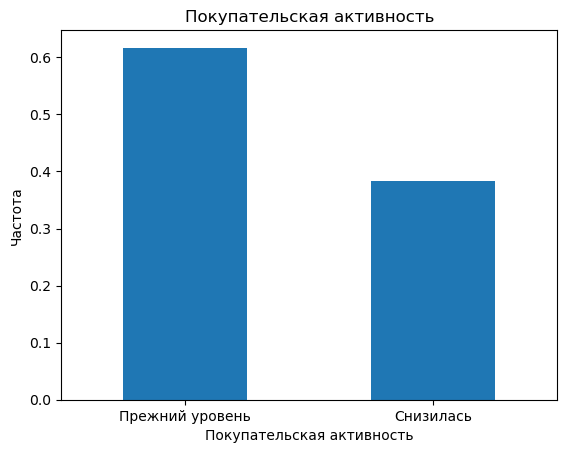

In [48]:
market_df['покупательская_активность'].value_counts(normalize=True).plot(kind='bar')
plt.title('Покупательская активность')
plt.xlabel('Покупательская активность')
plt.ylabel('Частота')
plt.xticks(rotation=0)
plt.show()

Около 60% клиентов сохранили прежний уровень активности, в то время как у примерно 40% клиентов активность снизилась. Это указывает на значительное количество клиентов, чья активность уменьшилась, что подтверждает необходимость разработки стратегий для удержания клиентов. Имеется некритичный дисбаланс классов. Стоит учитывать это при обучении модели.

#### тип_сервиса

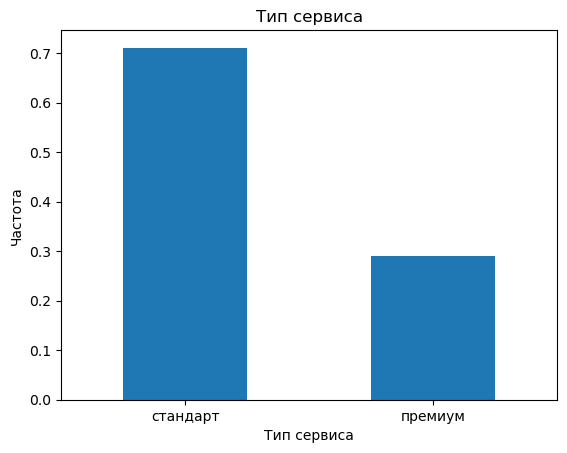

In [49]:
market_df['тип_сервиса'].value_counts(normalize=True).plot(kind='bar')
plt.title('Тип сервиса')
plt.xlabel('Тип сервиса')
plt.ylabel('Частота')
plt.xticks(rotation=0)
plt.show()

Примерно 70% клиентов пользуются стандартным типом сервиса, в то время как около 30% клиентов пользуются премиум-сервисом. Это говорит о том, что стандартный сервис значительно более популярен среди клиентов, чем премиум. Возможно, это связано с ценой перехода на премиум-сервис. Имеется дисбаланс классов.

#### разрешить_сообщать

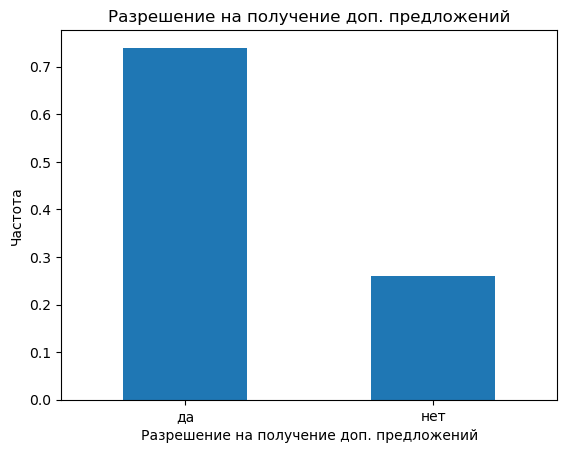

In [50]:
market_df['разрешить_сообщать'].value_counts(normalize=True).plot(kind='bar')
plt.title('Разрешение на получение доп. предложений')
plt.xlabel('Разрешение на получение доп. предложений')
plt.ylabel('Частота')
plt.xticks(rotation=0)
plt.show()

Около 70% клиентов дали согласие на получение дополнительных предложений, тогда как около 30% клиентов не дали такого разрешения. Имеется дисбаланс классов.

#### популярная_категория

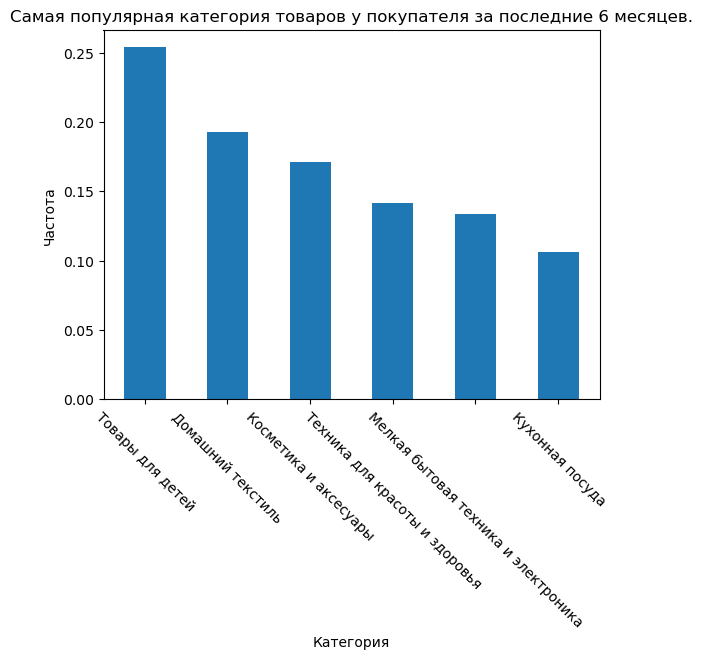

In [51]:
market_df['популярная_категория'].value_counts(normalize=True).plot(kind='bar')
plt.title('Самая популярная категория товаров у покупателя за последние 6 месяцев.')
plt.xlabel('Категория')
plt.ylabel('Частота')
plt.xticks(rotation=-45)
plt.show()

иболее популярная категория — это «Товары для детей», которая составляет около 25% всех покупок. Следом идут «Домашний текстиль» и «Косметика и аксессуары». Меньше всего покупатели интересуются «Кухонной посудой». Имеется незначительный дисбаланс классов.

#### маркет_актив_6_мес

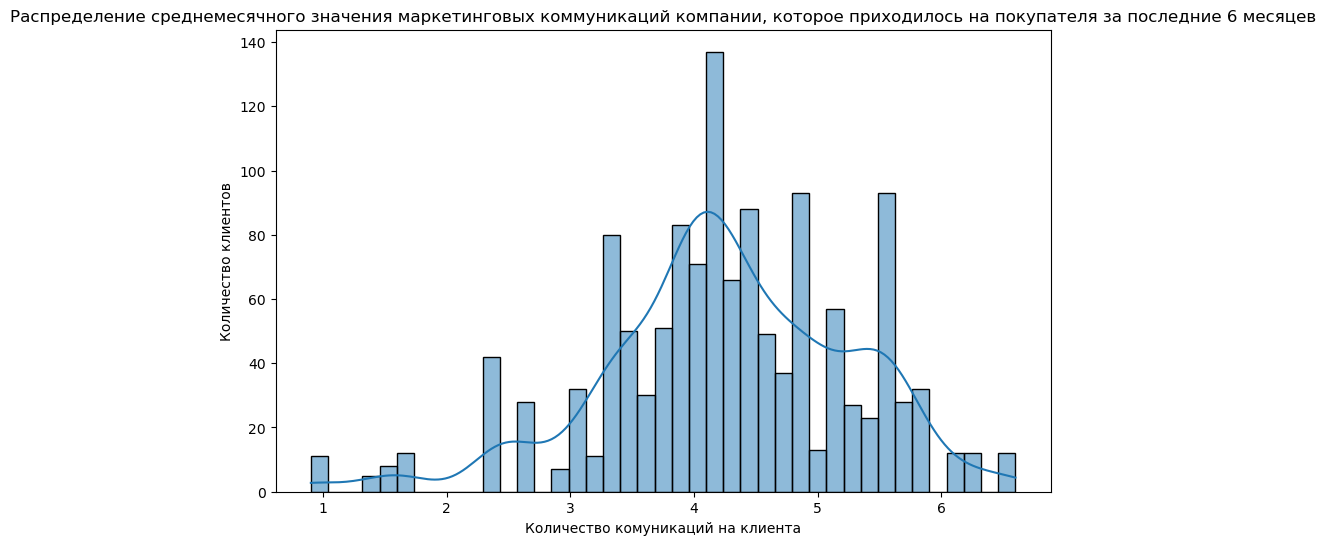

In [52]:
plt.figure(figsize=(10, 6))
sns.histplot(market_df['маркет_актив_6_мес'], bins=market_df['маркет_актив_6_мес'].nunique(), kde=True)
plt.title('Распределение среднемесячного значения маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев')
plt.xlabel('Количество комуникаций на клиента')
plt.ylabel('Количество клиентов')
plt.show()

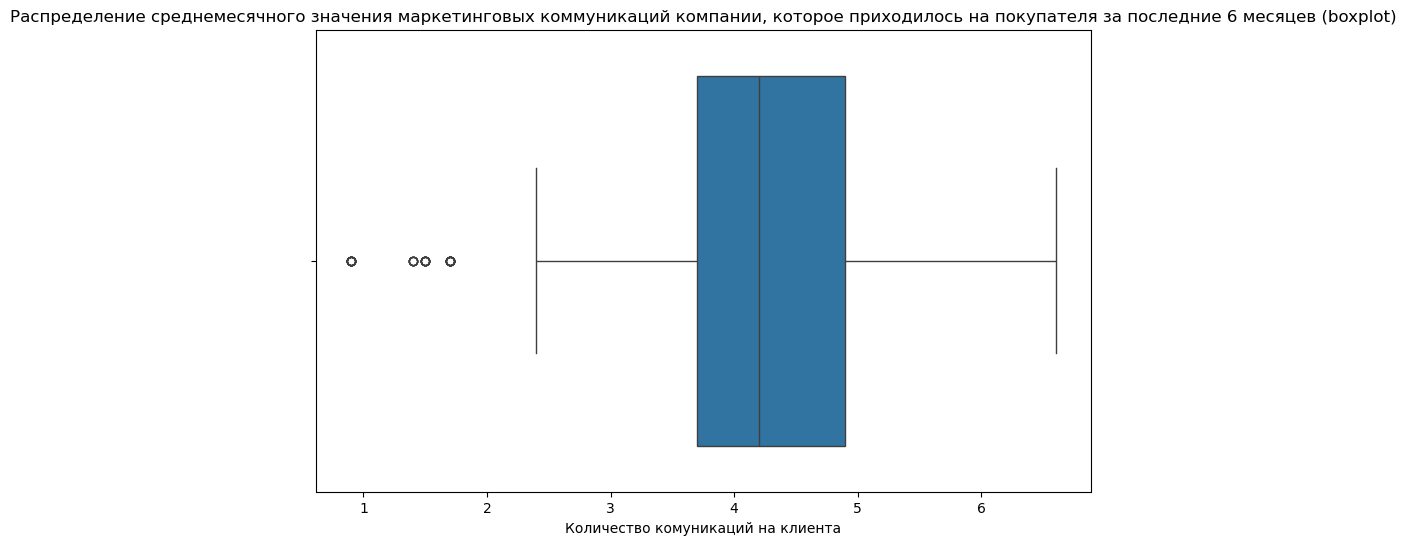

In [53]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=market_df['маркет_актив_6_мес'])
plt.title('Распределение среднемесячного значения маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев (boxplot)')
plt.xlabel('Количество комуникаций на клиента')
plt.show()

**Выводы:**
- Большинство клиентов получали от 3 до 5 маркетинговых коммуникаций в месяц, с пиком на уровне 4. Распределение близко к нормальному с небольшим правым перекосом.
- Имеются небольшие отклонения, но их нельзя классифицировать как выброс.
- Большинство клиентов получают регулярные маркетинговые сообщения, что является важной информацией для планирования дальнейших стратегий.

#### маркет_актив_тек_мес

In [54]:
market_df['маркет_актив_тек_мес'].value_counts()

4    669
5    323
3    308
Name: маркет_актив_тек_мес, dtype: int64

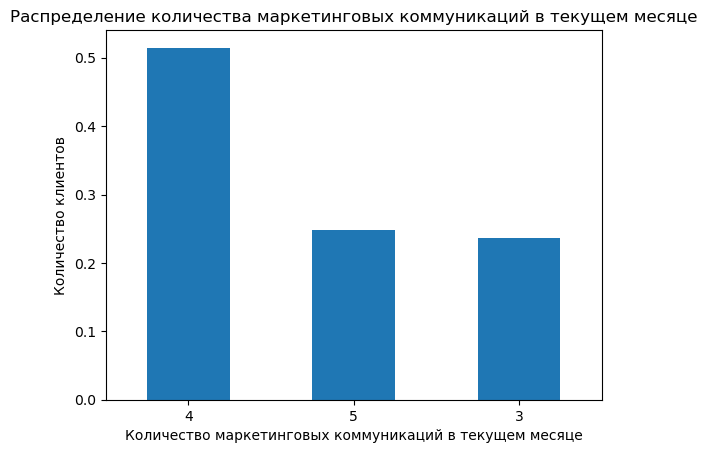

In [55]:
market_df['маркет_актив_тек_мес'].value_counts(normalize=True).plot(kind='bar')
plt.title('Распределение количества маркетинговых коммуникаций в текущем месяце')
plt.xlabel('Количество маркетинговых коммуникаций в текущем месяце')
plt.ylabel('Количество клиентов')
plt.xticks(rotation=0)
plt.show()

**Выводы:**
- Наибольшее количество клиентов (668) получили около 4 маркетинговых коммуникаций в текущем месяце.
- Около 300 клиентов получили по 3 и 5 коммуникаций соответственно.
- Распределение имеет две группы с пиками на 3 и 4 коммуникации, что может свидетельствовать о стандартных стратегиях рассылок.
- Имеется незначительный дисбаланс классов

Таким образом, большинство клиентов получили 4 маркетинговых коммуникации в текущем месяце, что является основным показателем взаимодействия с клиентами.

#### длительность

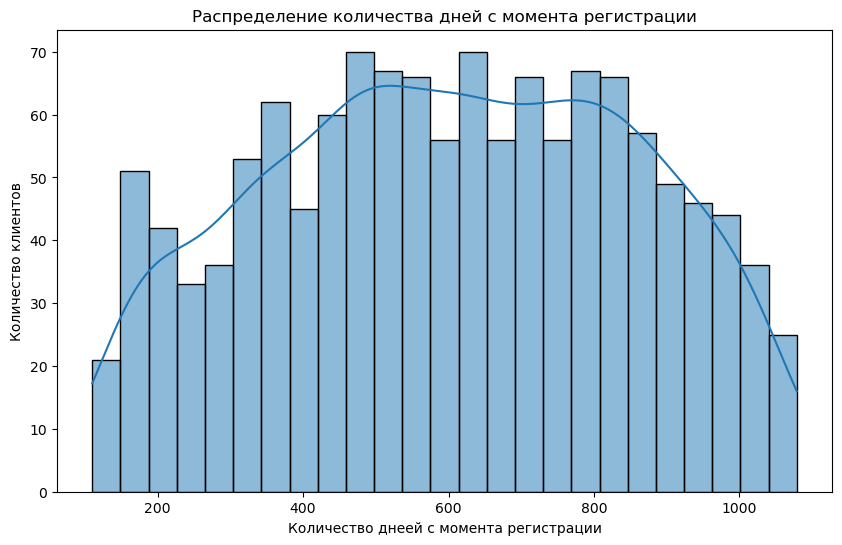

In [56]:
plt.figure(figsize=(10, 6))
sns.histplot(market_df['длительность'], bins=25, kde=True)
plt.title('Распределение количества дней с момента регистрации')
plt.xlabel('Количество днеей с момента регистрации')
plt.ylabel('Количество клиентов')
plt.show()

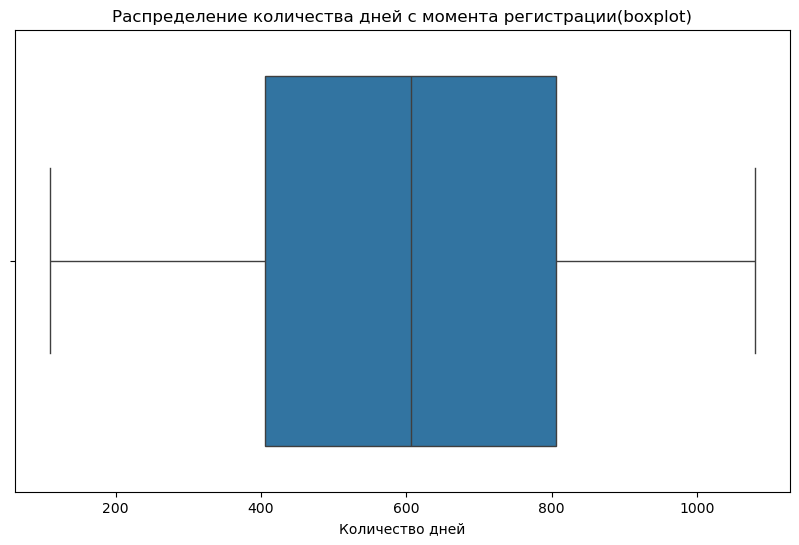

In [57]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=market_df['длительность'])
plt.title('Распределение количества дней с момента регистрации(boxplot)')
plt.xlabel('Количество дней')
plt.show()

**Выводы:**
- Большинство клиентов зарегистрировались на сайте в диапазоне от 400 до 800 дней назад, что свидетельствует о наличии устойчивой клиентской базы.
- Пик распределения приходится на около 600 дней с момента регистрации.
- Распределение близко к нормальному, но с несколькими незначительными пиками, что указывает на равномерное распределение клиентов по времени регистрации.
- Значительных выбросов и аномалий не наблюдается.

#### акционные_покупки

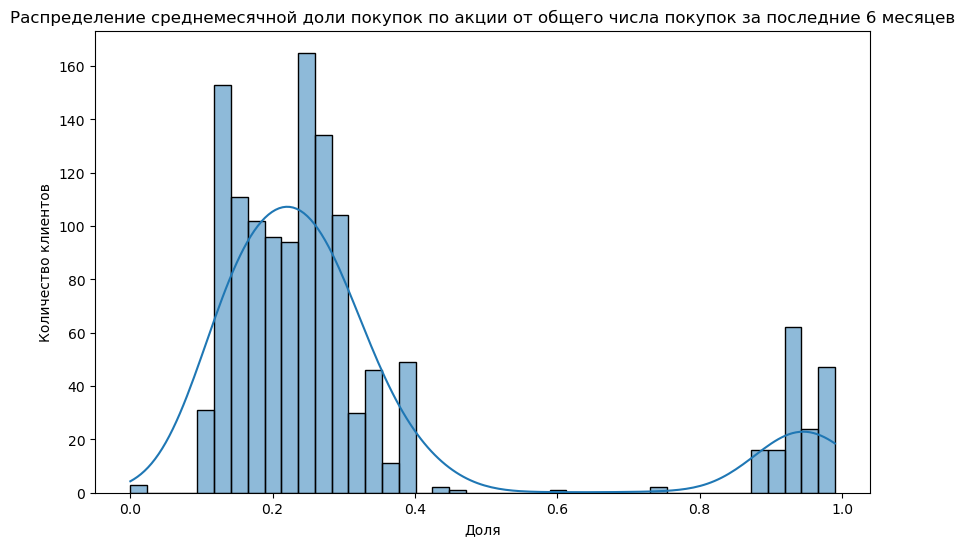

In [58]:
plt.figure(figsize=(10, 6))
sns.histplot(market_df['акционные_покупки'], bins=market_df['акционные_покупки'].nunique(), kde=True)
plt.title('Распределение среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев')
plt.xlabel('Доля')
plt.ylabel('Количество клиентов')
plt.show()

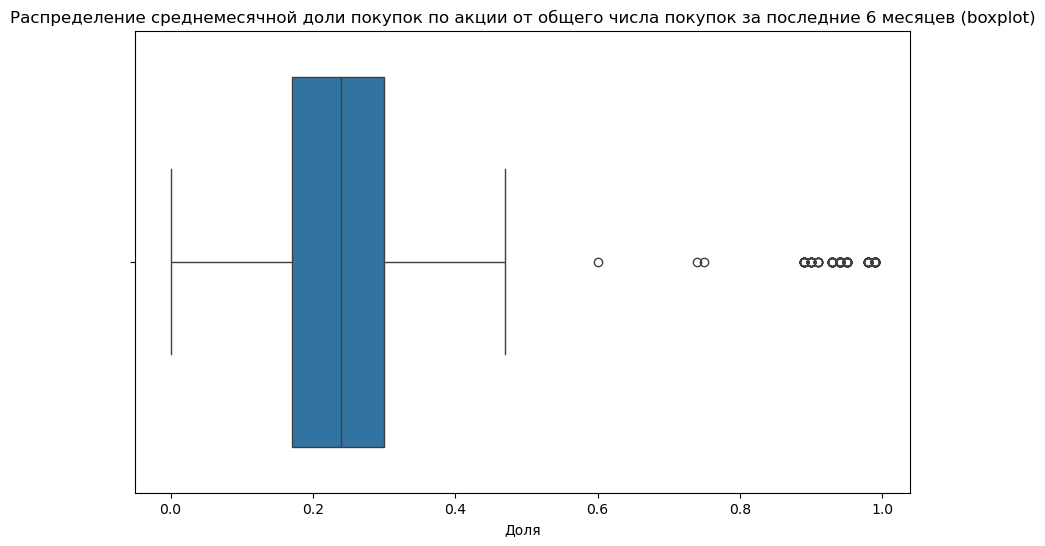

In [59]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=market_df['акционные_покупки'])
plt.title('Распределение среднемесячной доли покупок по акции от общего числа покупок за последние 6 месяцев (boxplot)')
plt.xlabel('Доля')
plt.show()

**Выводы:**
- Большинство клиентов имеют долю покупок по акциям от 0 до 0.4, с пиком около 0.2.
- Наблюдаются дополнительный пик в диапазоне 0.9-1.0, что указывает на клиентов, которые совершают почти все свои покупки по акциям.
- Распределение имеет два явных пика, что свидетельствует о наличии двух групп клиентов: тех, кто активно пользуется акциями, и тех, кто делает это редко.
- Выбросы отсутствуют

Таким образом, большинство клиентов совершают менее 40% своих покупок по акциям, но существует значительная группа клиентов, которые совершают почти все свои покупки по акциям.

#### средний_просмотр_категорий_за_визит

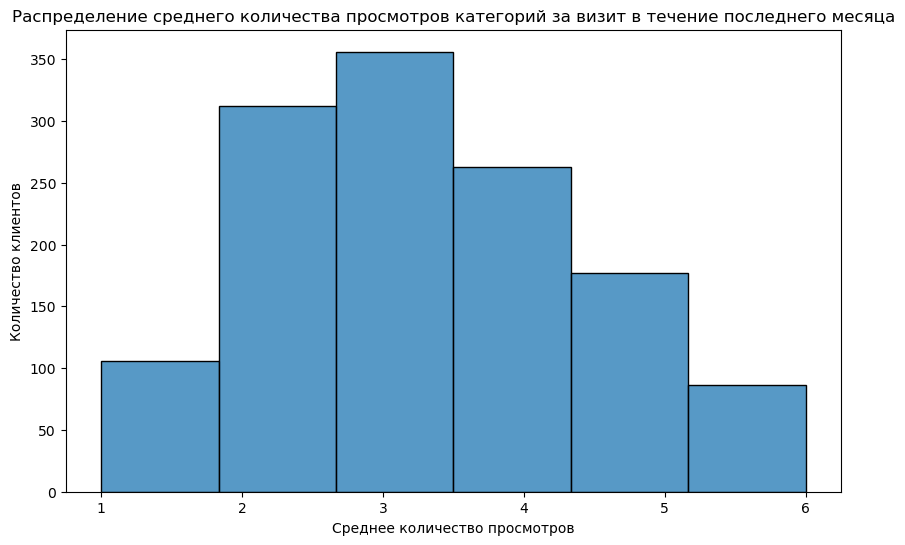

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(market_df['средний_просмотр_категорий_за_визит'], bins=market_df['средний_просмотр_категорий_за_визит'].nunique())
plt.title('Распределение среднего количества просмотров категорий за визит в течение последнего месяца')
plt.xlabel('Среднее количество просмотров')
plt.ylabel('Количество клиентов')
plt.show()

**Выводы:**
- Большинство клиентов просматривали от 2 до 4 категорий за визит.
- Пик распределения приходится на 3 категории за визит.
- Распределение имеет форму нормальной кривой с небольшим правым перекосом, что указывает на некоторых клиентов, просматривающих большее количество категорий.

Таким образом, большинство клиентов обычно просматривают от 2 до 4 категорий за один визит на сайт, что свидетельствует о среднем уровне заинтересованности в ассортименте магазина.

#### неоплаченные_продукты_штук_квартал

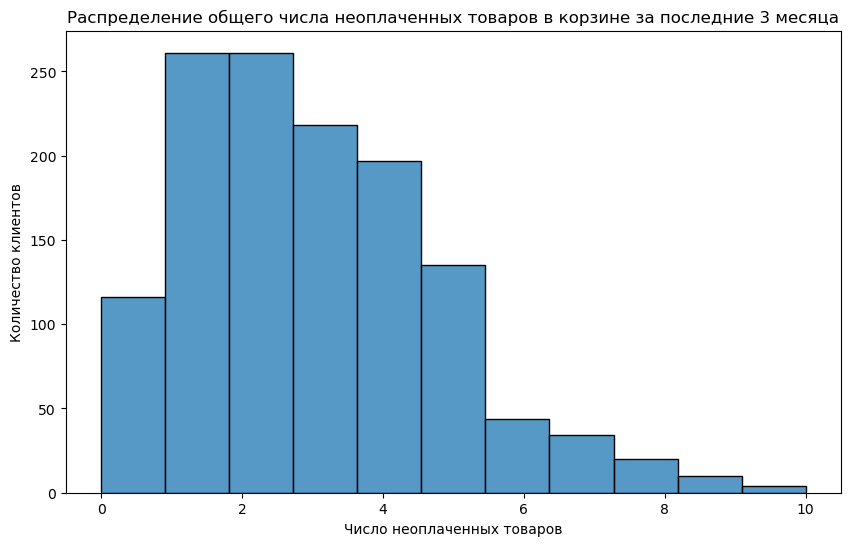

In [61]:
plt.figure(figsize=(10, 6))
sns.histplot(market_df['неоплаченные_продукты_штук_квартал'], bins=market_df['неоплаченные_продукты_штук_квартал'].nunique())
plt.title('Распределение общего числа неоплаченных товаров в корзине за последние 3 месяца')
plt.xlabel('Число неоплаченных товаров')
plt.ylabel('Количество клиентов')
plt.show()

**Выводы:**
- Большинство клиентов имеют от 0 до 3 неоплаченных товаров в корзине.
- Пик распределения приходится на 2 неоплаченных товара.
- Распределение имеет левый перекос, что указывает на то, что у большинства клиентов мало неоплаченных товаров в корзине.

Таким образом, большинство клиентов оставляют в корзине от 0 до 3 товаров неоплаченными, что свидетельствует о необходимости улучшения процесса завершения покупок и уменьшения числа брошенных корзин.

#### ошибка_сервиса

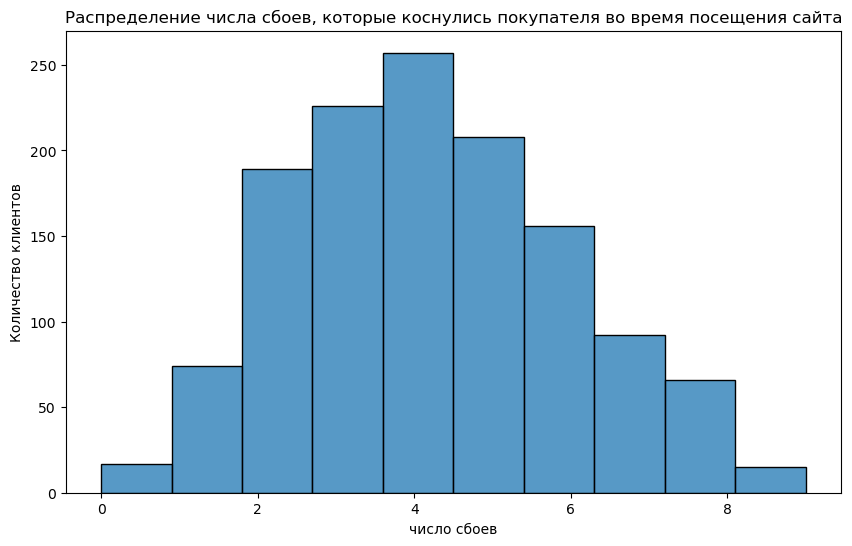

In [62]:
plt.figure(figsize=(10, 6))
sns.histplot(market_df['ошибка_сервиса'], bins=market_df['ошибка_сервиса'].nunique())
plt.title('Распределение числа сбоев, которые коснулись покупателя во время посещения сайта')
plt.xlabel('число сбоев')
plt.ylabel('Количество клиентов')
plt.show()

**Выводы:**
- Большинство клиентов столкнулись с 3-5 сбоями во время посещения сайта.
- Пик распределения приходится на 4 сбоя.
- Распределение симметрично и имеет форму нормальной кривой.

Таким образом, большинство клиентов испытывают от 3 до 5 сбоев при посещении сайта, что является довольно большим показателем и может негативно влиять на их покупательскую активность и удовлетворенность.

#### страниц_за_визит

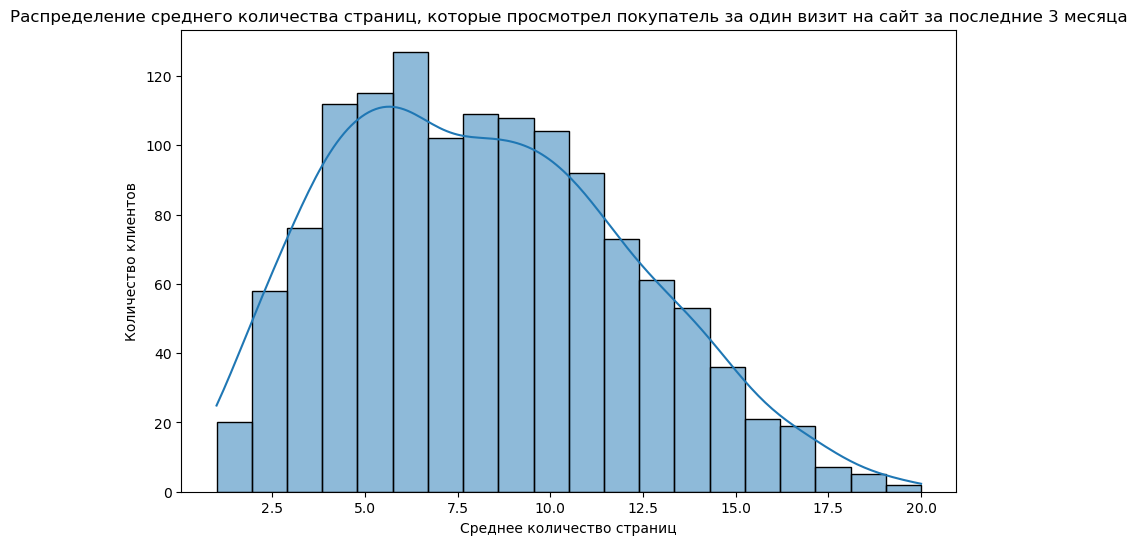

In [63]:
plt.figure(figsize=(10, 6))
sns.histplot(market_df['страниц_за_визит'], bins=market_df['страниц_за_визит'].nunique(), kde=True)
plt.title('Распределение среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца')
plt.xlabel('Среднее количество страниц')
plt.ylabel('Количество клиентов')
plt.show()

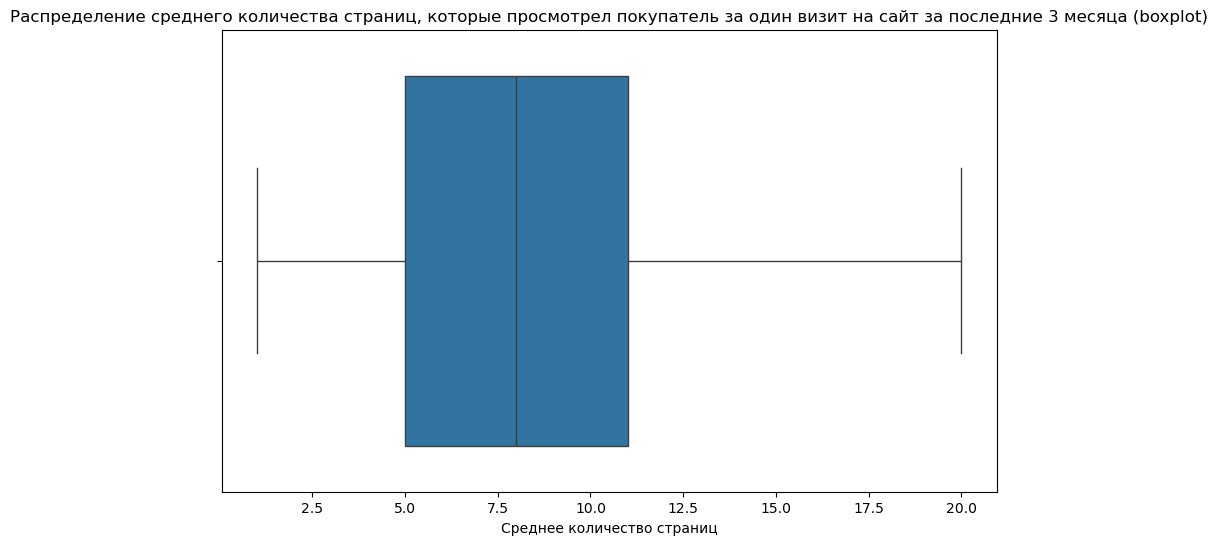

In [64]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=market_df['страниц_за_визит'])
plt.title('Распределение среднего количества страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца (boxplot)')
plt.xlabel('Среднее количество страниц')
plt.show()

**Выводы:**
- Большинство клиентов просматривали от 5 до 10 страниц за визит.
- Пик распределения приходится на 7 страниц за визит.
- Распределение имеет форму нормальной кривой с легким правым перекосом, что указывает на некоторых клиентов, просматривающих большее количество страниц.
- Выбросов и аномалий не наблюдается.

Таким образом, большинство клиентов обычно просматривают от 5 до 10 страниц за один визит на сайт, что свидетельствует о среднем уровне заинтересованности в содержимом сайта и продуктах магазина.

### market_money_df

In [65]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   период   3900 non-null   object 
 2   выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.9+ KB


#### Выручка

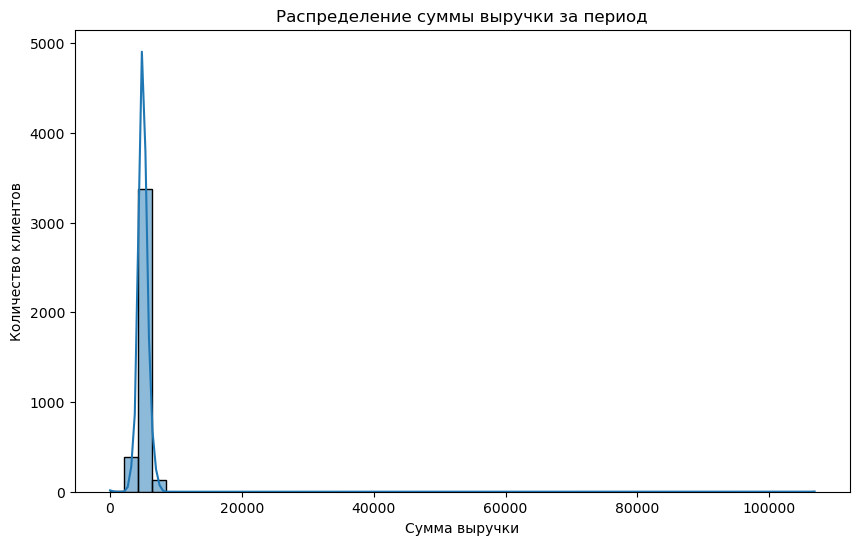

In [66]:
plt.figure(figsize=(10, 6))
sns.histplot(market_money_df['выручка'], bins=50, kde=True)
plt.title('Распределение суммы выручки за период')
plt.xlabel('Сумма выручки')
plt.ylabel('Количество клиентов')
plt.show()

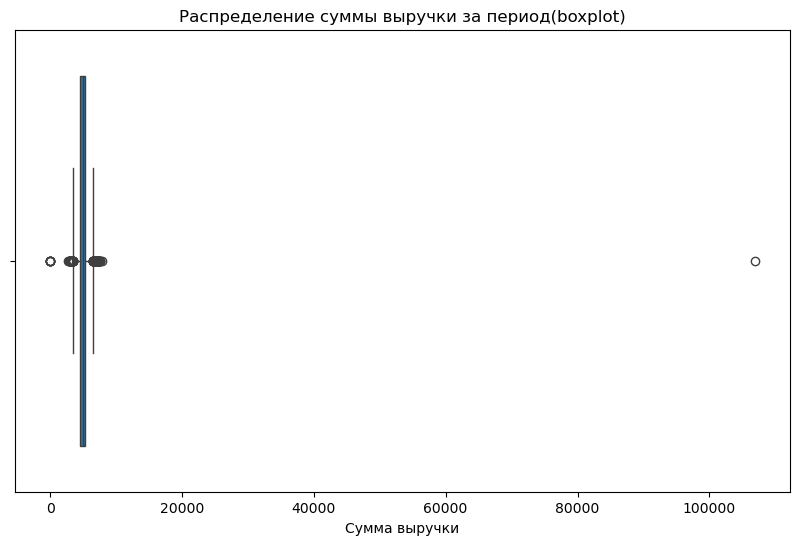

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=market_money_df['выручка'])
plt.title('Распределение суммы выручки за период(boxplot)')
plt.xlabel('Сумма выручки')
plt.show()

Имеем один выброс со значением больше 100_000. Избавимся от него

In [68]:
market_money_df[market_money_df['выручка'] > 20000]

,id,период,выручка
98,215380,текущий_месяц,106862.2


In [69]:
market_money_df = market_money_df[market_money_df['выручка'] < 20000]

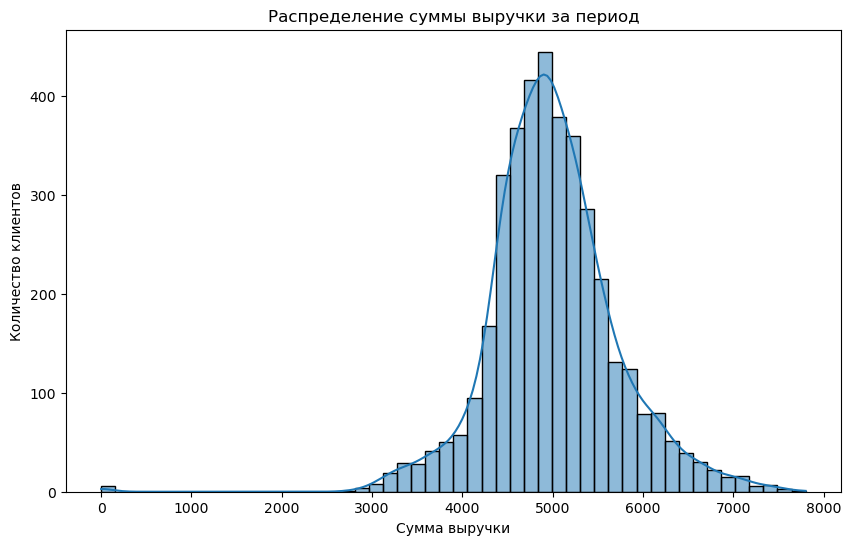

In [70]:
plt.figure(figsize=(10, 6))
sns.histplot(market_money_df['выручка'], bins=50, kde=True)
plt.title('Распределение суммы выручки за период')
plt.xlabel('Сумма выручки')
plt.ylabel('Количество клиентов')
plt.show()

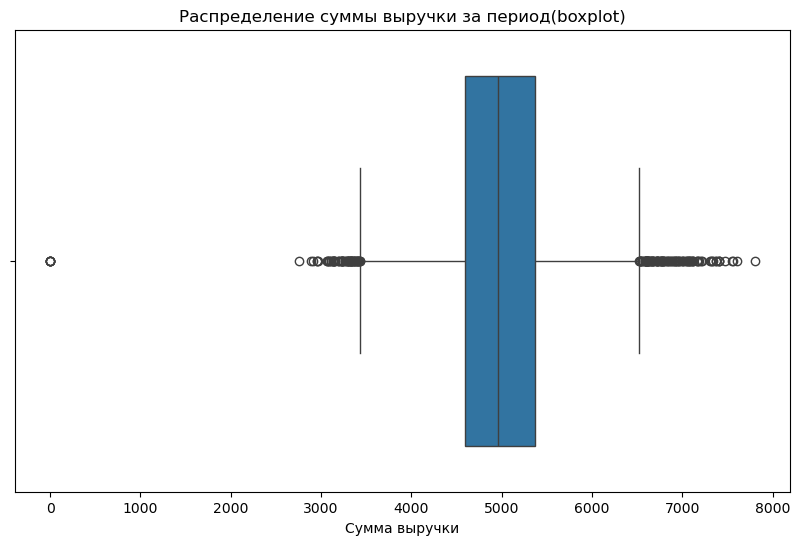

In [71]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=market_money_df['выручка'])
plt.title('Распределение суммы выручки за период(boxplot)')
plt.xlabel('Сумма выручки')
plt.show()

Имеем выбросы в обласи нуля. Избавимся от них

In [72]:
market_money_df[market_money_df['выручка'] < 2000]

,id,период,выручка
0,215348,препредыдущий_месяц,0.0
2,215348,предыдущий_месяц,0.0
28,215357,препредыдущий_месяц,0.0
29,215357,предыдущий_месяц,0.0
34,215359,предыдущий_месяц,0.0
35,215359,препредыдущий_месяц,0.0


In [73]:
ids = market_money_df[market_money_df['выручка'] < 2000]['id'].values
ids

array([215348, 215348, 215357, 215357, 215359, 215359], dtype=int64)

In [74]:
market_money_df = market_money_df[~market_money_df['id'].isin(ids)]

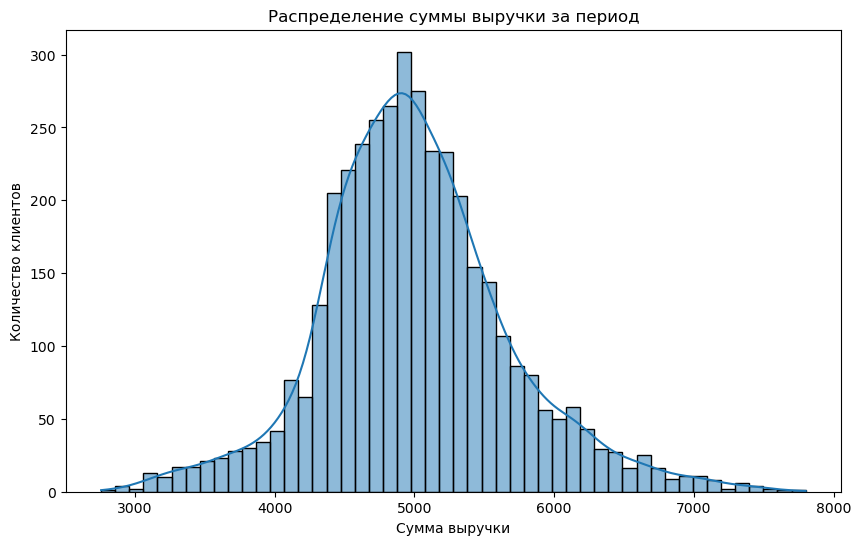

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(market_money_df['выручка'], bins=50, kde=True)
plt.title('Распределение суммы выручки за период')
plt.xlabel('Сумма выручки')
plt.ylabel('Количество клиентов')
plt.show()

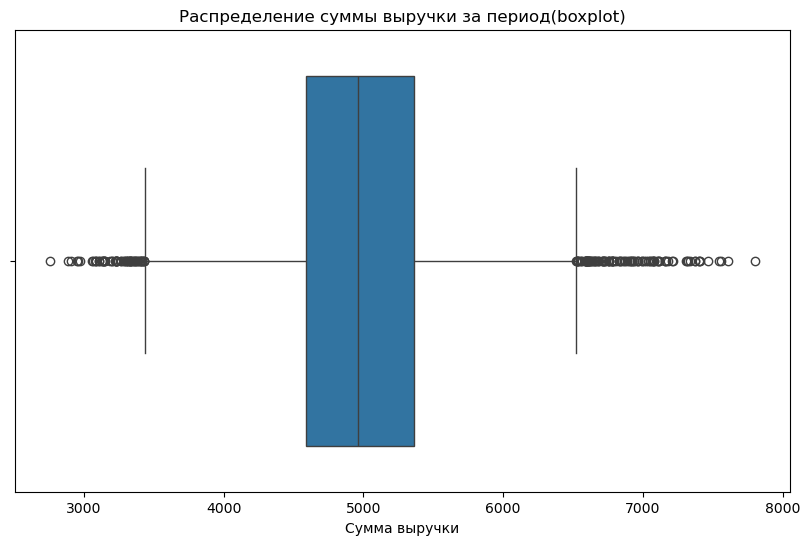

In [76]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=market_money_df['выручка'])
plt.title('Распределение суммы выручки за период(boxplot)')
plt.xlabel('Сумма выручки')
plt.show()

**Вывод:**
- Большинство клиентов приносят выручку в диапазоне от 4000 до 6000.
- Пик распределения приходится на сумму около 5000.
- Распределение близко к нормальному, с небольшой правой асимметрией.

Таким образом, большинство клиентов приносят выручку в диапазоне от 4000 до 6000, что является важной информацией для анализа клиентской базы и планирования маркетинговых стратегий.

#### период

In [77]:
market_money_df['период'].value_counts()

препредыдущий_месяц    1297
предыдущий_месяц       1297
текущий_месяц          1296
Name: период, dtype: int64

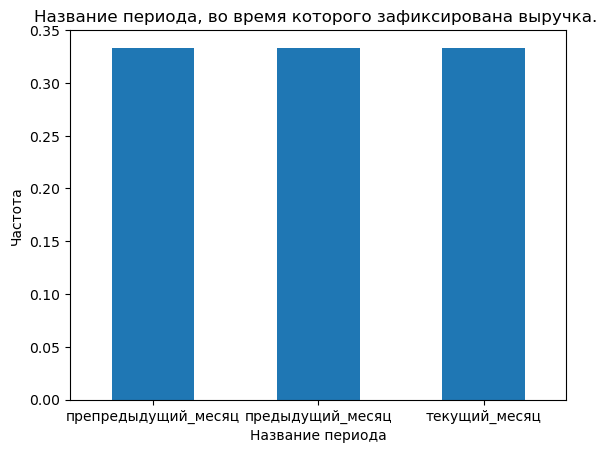

In [78]:
market_money_df['период'].value_counts(normalize=True).plot(kind='bar')
plt.title('Название периода, во время которого зафиксирована выручка. ')
plt.xlabel('Название периода')
plt.ylabel('Частота')
plt.xticks(rotation=0)
plt.show()

**Вывод:** Частота выручки за текущий, предыдущий и препредыдущий месяцы одинакова, составляя около 33% для каждого периода.
Это указывает на стабильный поток выручки в течение этих трёх месяцев.
Таким образом, выручка распределена равномерно по периодам, что свидетельствует о постоянной активности клиентов и отсутствии значительных колебаний в продажах в последние три месяца.

### market_time_df

In [79]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  2600 non-null   int64 
 1   период              2600 non-null   object
 2   время_на_сайте_мин  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 81.2+ KB


#### время_на_сайте_мин

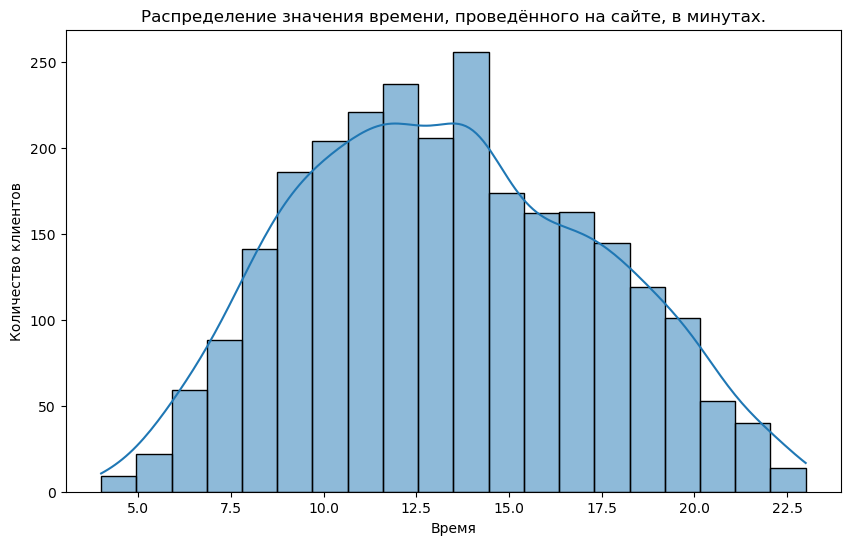

In [80]:
plt.figure(figsize=(10, 6))
sns.histplot(market_time_df['время_на_сайте_мин'], bins=market_time_df['время_на_сайте_мин'].nunique(), kde=True)
plt.title('Распределение значения времени, проведённого на сайте, в минутах.')
plt.xlabel('Время')
plt.ylabel('Количество клиентов')
plt.show()

**Выводы:**

- Большинство клиентов проводят на сайте от 10 до 15 минут.
- Пик распределения приходится на 12.5 минут.
- Распределение имеет форму нормальной кривой с небольшим правым перекосом, что указывает на некоторых клиентов, проводящих большее количество времени на сайте.

Таким образом, большинство клиентов проводят на сайте от 10 до 15 минут за визит, что свидетельствует о достаточном уровне вовлечённости и интереса к содержимому сайта.

#### период

In [81]:
market_time_df['период'].value_counts()

текущий_месяц       1300
предыдущий_месяц    1300
Name: период, dtype: int64

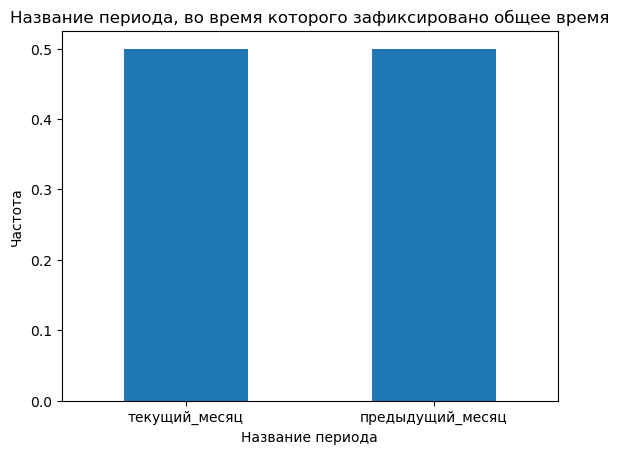

In [82]:
market_time_df['период'].value_counts(normalize=True).plot(kind='bar')
plt.title('Название периода, во время которого зафиксировано общее время')
plt.xlabel('Название периода')
plt.ylabel('Частота')
plt.xticks(rotation=0)
plt.show()

**Выводы:**
- Время, проведённое на сайте, за текущий и предыдущий месяцы распределено практически одинаково.
- Частота для каждого периода составляет 50%, что указывает на равномерное распределение активности клиентов по этим двум периодам.

Таким образом, общее время, проведённое клиентами на сайте, одинаково как в текущем, так и в предыдущем месяце, что свидетельствует о стабильной вовлечённости клиентов.

### money_df

In [83]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 30.5 KB


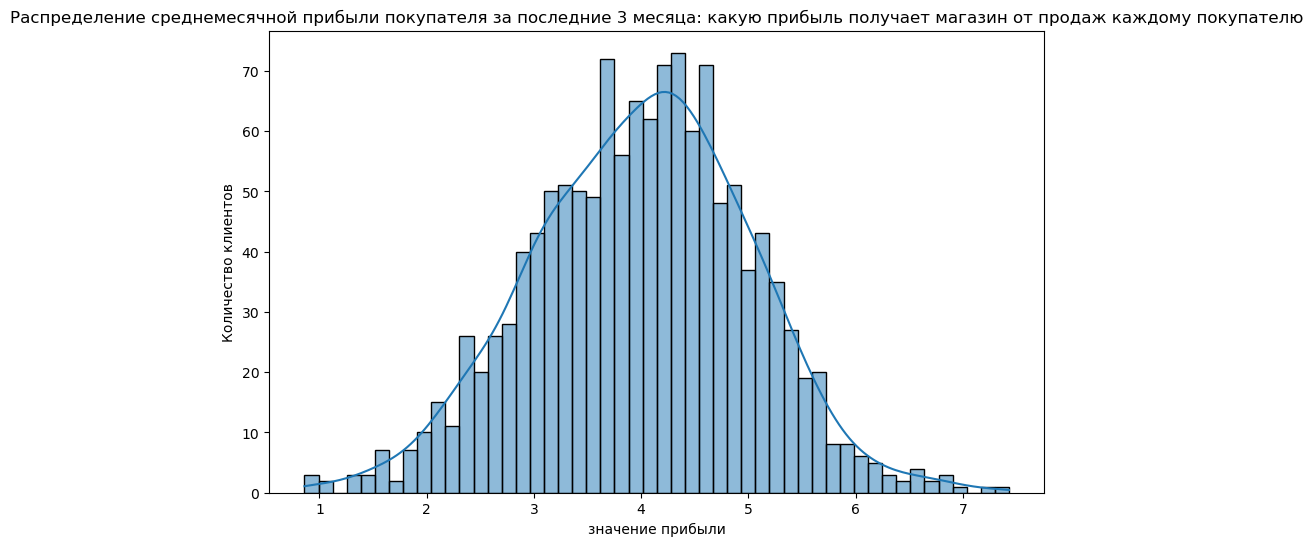

In [84]:
plt.figure(figsize=(10, 6))
sns.histplot(money_df['прибыль'], bins=50, kde=True)
plt.title('Распределение среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю')
plt.xlabel('значение прибыли')
plt.ylabel('Количество клиентов')
plt.show()

**Выводы:**
- Большинство клиентов приносят среднемесячную прибыль от 3 до 5.
- Пик распределения приходится на значение около 4.
- Распределение близко к нормальному с правой асимметрией, что указывает на наличие клиентов с более высокой прибылью.

Таким образом, большинство клиентов приносят среднемесячную прибыль в диапазоне от 3 до 5, что свидетельствует о стабильной базе доходов с некоторыми клиентами, приносящими значительно больше прибыли.

## Объединение таблиц

In [85]:
market_money_pivot = market_money_df.pivot(index='id', columns='период', values='выручка').reset_index()
market_money_pivot.columns = ['id', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц']

market_time_pivot = market_time_df.pivot(index='id', columns='период', values='время_на_сайте_мин').reset_index()
market_time_pivot.columns = ['id', 'время_препредыдущий_месяц', 'время_предыдущий_месяц']

print(market_money_pivot.head())
market_time_pivot.head()

       id  выручка_препредыдущий_месяц  выручка_предыдущий_месяц  \
0  215349                       5216.0                    4472.0   
1  215350                       5457.5                    4826.0   
2  215351                       6158.0                    4793.0   
3  215352                       5807.5                    4594.0   
4  215353                       4738.5                    5124.0   

   выручка_текущий_месяц  
0                 4971.6  
1                 5058.4  
2                 6610.4  
3                 5872.5  
4                 5388.5  


,id,время_препредыдущий_месяц,время_предыдущий_месяц
0,215348,13,14
1,215349,12,10
2,215350,8,13
3,215351,11,13
4,215352,8,11


In [86]:
print("Размерность market_df:", market_df.shape)
print("Размерность market_money_df:", market_money_pivot.shape)
print("Размерность market_time_df:", market_time_pivot.shape)

Размерность market_df: (1300, 13)
Размерность market_money_df: (1297, 4)
Размерность market_time_df: (1300, 3)


In [87]:
df = pd.merge(market_df, market_money_pivot, on='id', how='left')
df = pd.merge(df, market_time_pivot, on='id', how='left')

print("Размерность объединенного датафрейма:", df.shape)
df.head()

Размерность объединенного датафрейма: (1300, 18)


,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,время_препредыдущий_месяц,время_предыдущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,NaN,NaN,NaN,13,14
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11


In [88]:
df.isna().sum()

id                                     0
покупательская_активность              0
тип_сервиса                            0
разрешить_сообщать                     0
маркет_актив_6_мес                     0
маркет_актив_тек_мес                   0
длительность                           0
акционные_покупки                      0
популярная_категория                   0
средний_просмотр_категорий_за_визит    0
неоплаченные_продукты_штук_квартал     0
ошибка_сервиса                         0
страниц_за_визит                       0
выручка_препредыдущий_месяц            3
выручка_предыдущий_месяц               3
выручка_текущий_месяц                  4
время_препредыдущий_месяц              0
время_предыдущий_месяц                 0
dtype: int64

In [89]:
df[df['выручка_предыдущий_месяц'].isna()]

,id,покупательская_активность,тип_сервиса,разрешить_сообщать,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,популярная_категория,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,время_препредыдущий_месяц,время_предыдущий_месяц
0,215348,Снизилась,премиум,да,3.4,5,121,0.0,Товары для детей,6,2,1,5,NaN,NaN,NaN,13,14
9,215357,Снизилась,стандарт,да,3.9,5,154,0.0,Техника для красоты и здоровья,3,3,9,5,NaN,NaN,NaN,12,6
11,215359,Снизилась,стандарт,да,4.6,5,110,0.0,Домашний текстиль,4,2,4,2,NaN,NaN,NaN,13,11


После объединения получили ожидаемое количество столбцов. Но имеем 4 записи, в которых значения выручки = NaN. Скорее всего, это клиенты, информация по выручке для которых, отсутствует по разным причинам (например, техническим). Дабы исключить возможные проблемы и искажения в исследовании, избавимся от этих записей.

Так же имеем запись в которых значение выручки за текущий месяц отсутствует (NaN). Заполним такие пропуски 0, то есть будем расценивать такие пропуски как отсутсвие покупок со стороны клиента за текущий месяц

In [90]:
df = df[~df['выручка_предыдущий_месяц'].isna()]
df['выручка_текущий_месяц'] = df['выручка_текущий_месяц'].fillna(0)


df.shape

(1297, 18)

## Корреляционный анализ

In [91]:
corr_matrix = df.drop('id', axis=1).phik_matrix(interval_cols=['маркет_актив_6_мес', 'длительность', 'акционные_покупки', 'выручка_препредыдущий_месяц', 'выручка_предыдущий_месяц', 'выручка_текущий_месяц'])

**Выводы:**

- `выручка_препредыдущий_месяц` и `выручка_текущий_месяц` имеют высокую положительную корреляцию (0.83). Это указывает на возможную мультиколлинеарность между этими признаками. Но это вполне нормально, поскольку разница между этими временными отрезками минимальна, то есть вряд ли клиент который потратил за прошлый месяц 1000 рублей, потратит намного меньше на следующий месяц (если не случится ничего необычного). Не будем отбрасывать этот столбец, поскольку он может дать нам информацию о том, сколько тратит клиент.
- Анализ phik матрицы корелляции показывает, что целевой признак имеет не нулевую корреляцию с большинством признаком. Более того, есть немало признаков с большим кф-том корреляции, среди них `страниц_за_визит`, `врем_препредыдущий_месяц`, `маркет_актив_6_мес`, что является хорошим знаком, поскольку эти признаки будут вносить значительный вклад в предсказание модели.

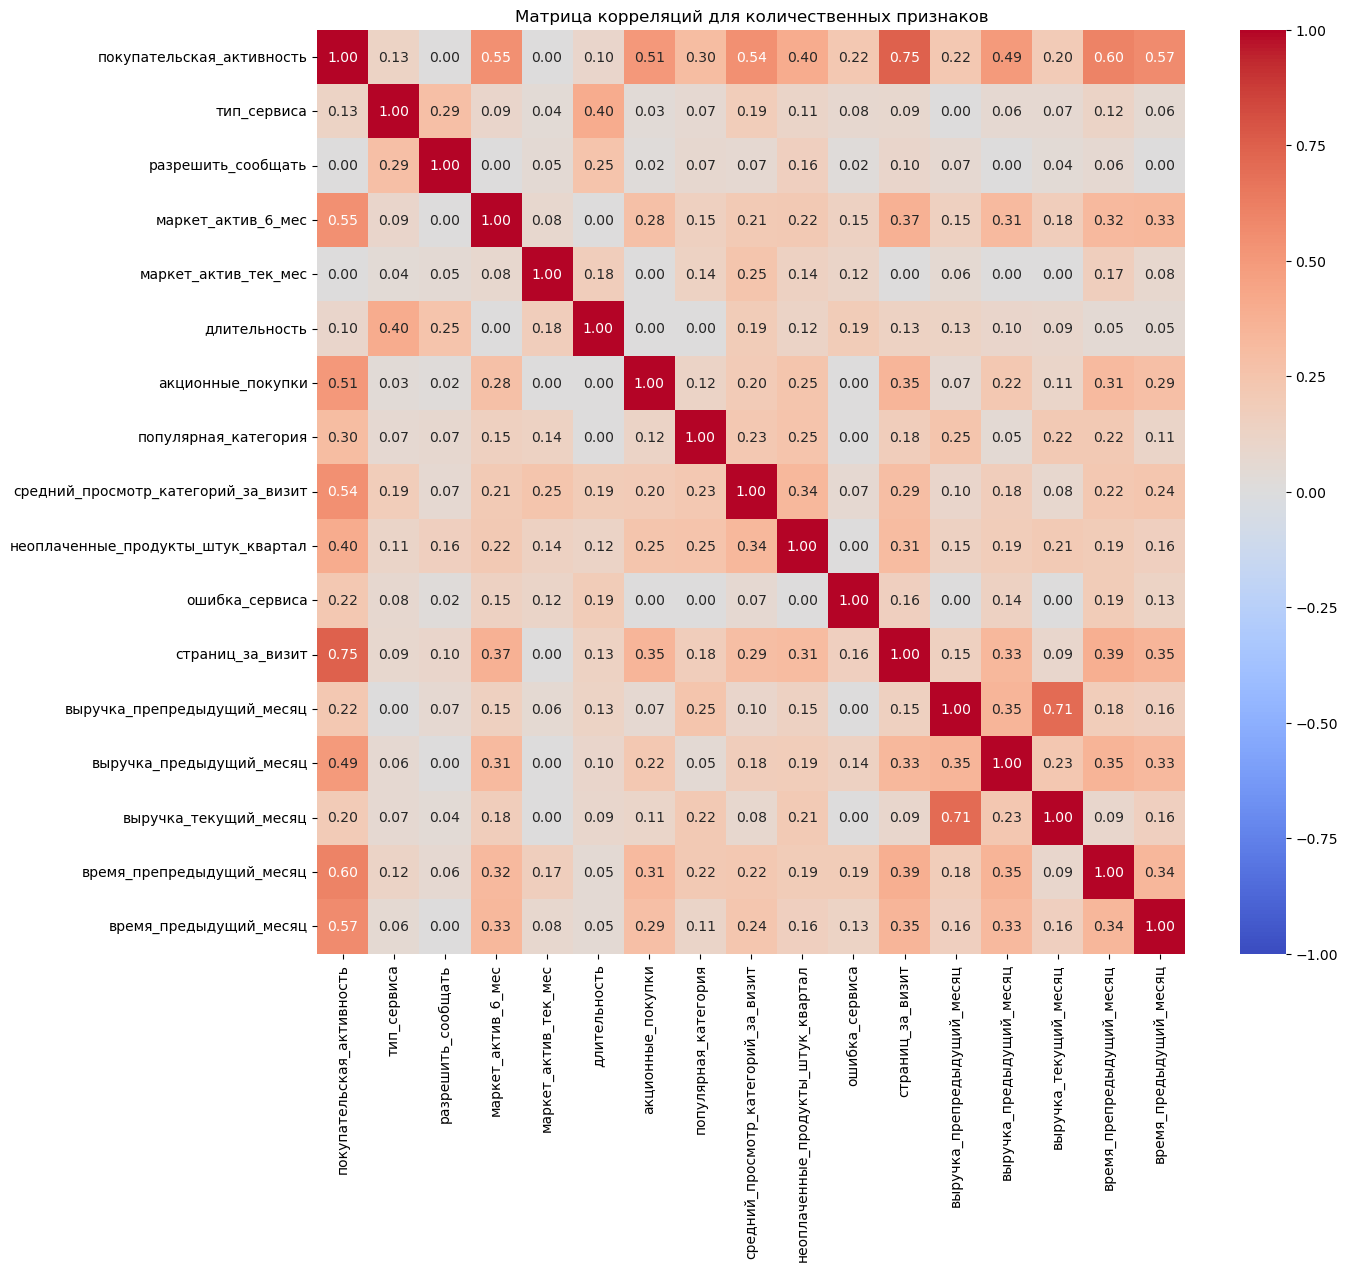

In [92]:
plt.figure(figsize=(14, 12))
sns.heatmap(
    corr_matrix, 
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    vmin=-1,
    vmax=1
)
plt.title('Матрица корреляций для количественных признаков')
plt.show()

## Использование пайплайнов

In [93]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

X = df.drop(['id', 'покупательская_активность'], axis=1)
y = df['покупательская_активность']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE, 
    random_state = RANDOM_STATE,
stratify=y)

In [94]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [95]:
num_columns = ['маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',	
               'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 'ошибка_сервиса', 
               'страниц_за_визит', 'выручка_предыдущий_месяц', 'выручка_препредыдущий_месяц', 'выручка_текущий_месяц',
               'время_препредыдущий_месяц', 'время_предыдущий_месяц']
ohe_columns = ['популярная_категория']
ordinal_encoder_columns = ['тип_сервиса', 'разрешить_сообщать']

In [96]:
ohe_pipe = Pipeline(
    [
        ('simpleImputer_before_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore')),
        (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

ordinal_encoder_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    ['стандарт', 'премиум'],
                    ['нет', 'да'],
                ], 
                handle_unknown='use_encoded_value',
                unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ordinal_encoder_pipe, ordinal_encoder_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [97]:
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.01, 0.1, 1, 3, 5],
        'models__kernel': ['poly', 'rbf'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler()]  
    },
]

In [98]:
cv = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

cv.fit(X_train, y_train);

In [99]:
print(f"Лучшая метрика: {cv.best_score_}")
print(f"Лучшая модель: {cv.best_estimator_}")

Лучшая метрика: 0.9145541334723152
Лучшая модель: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_before_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore')),
                                                                  ('simpleImputer_after_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['популярная_категория']),
                                     

In [100]:
best_model = cv.best_estimator_

In [101]:
roc_auc_score(y_train, best_model.predict_proba(X_train)[:, 1])

0.9688614214404564

In [102]:
roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])

0.9171080083453699

In [103]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)

print(f"Значение roc_auc для DummyClassifier на тестовой выборке = {roc_auc_score(y_test, dummy_clf.predict_proba(X_test)[:, 1])}")

Значение roc_auc для DummyClassifier на тестовой выборке = 0.5


**Вывод:**
Полученная модель значительно обходит DummyClassifier по значению метрики roc_auc, что, как минимум, говорит о том, что вся наша работа по трансформации и выбору модели была не напрасна

In [104]:
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

roc_auc = roc_auc_score(y_test, y_pred_proba)

print("Отчет по классификации:")
print(classification_report(y_test, y_pred, zero_division=False))

Отчет по классификации:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93       201
           1       0.94      0.81      0.87       124

    accuracy                           0.91       325
   macro avg       0.92      0.89      0.90       325
weighted avg       0.91      0.91      0.91       325



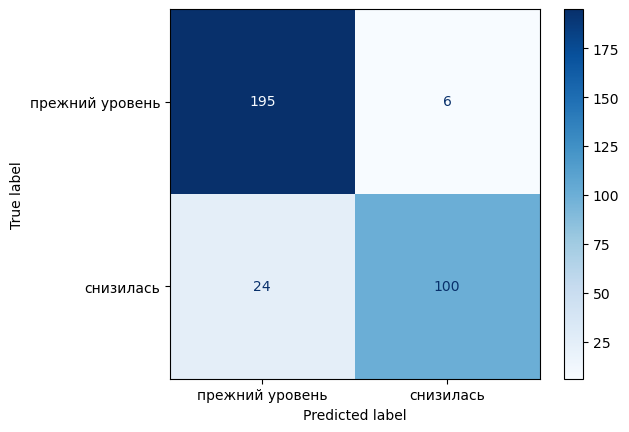

In [117]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['прежний уровень', 'снизилась'])
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Выводы:**
- Модель хорошо справляется с идентификацией клиентов, которые сохраняют прежний уровень покупательской активности (TN=195).
- Модель также достаточно точно предсказывает снижение активности (TP=100), что позволяет целенаправленно работать с этими клиентами.
- Количество ложно положительных (FP=6) и ложно отрицательных (FN=24) ошибок находится в допустимых пределах, но их также следует учитывать при разработке маркетинговых стратегий.
- Основное внимание следует уделить ложно отрицательным случаям, так как эти клиенты могут покинуть платформу, если вовремя не принять меры для их удержания.

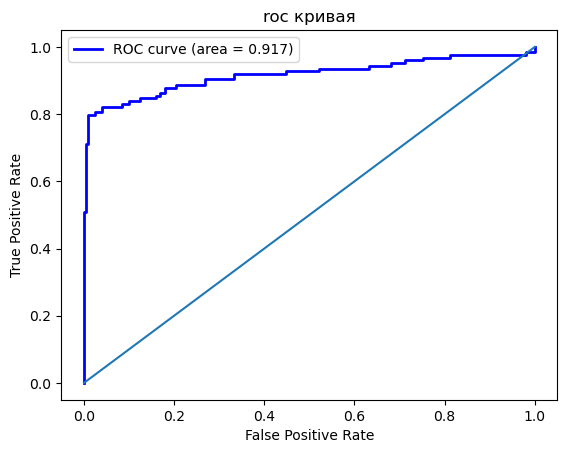

In [106]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('roc кривая')
plt.legend()
plt.show()

**Выводы:**
1. В качестве метрики был выбран `roc_auc`, поскольку он хорошо подходит для задач, где важно оценить способность модели различать между положительными и отрицательными классами, независимо от порога. _В качестве альтернативы, можно было бы использовать `f1-score`, который Подходит для задач с дисбалансом классов, так как она учитывает и точность, и полноту, балансируя их, но в нашем случае дисбаланс не является критичным, плюс к этому мы производили статификацию, что позволяет нам не использовать `f1-score`._
2. Основываясь на показатель метрики была выбрана наилучшая модель SVC с гиперпараметрами `C=1`, `kernel='rbf'` с использованием `StandardScaler`. Выбор модели с указанными гиперпараметрами, вполне логичен для задачи бинарной классификации. SVC с радиальной базисной функцией (`rbf`) ядра часто оказывается одним из лучших вариантов для задач бинарной классификации, особенно когда данные имеют нелинейные границы раздела.
3. Значение метрики на тренировочных данных 0.92, на тестовых 0.91. Значения метрик неплохие, признаки переобучения отсутствуют. 

## Анализ важности признаков

In [107]:
X_test_transformed = best_model.named_steps['preprocessor'].fit_transform(X_test)

# Использование метода kmeans для уменьшения количества образцов
background = shap.kmeans(X_test_transformed, 100)
explainer = shap.KernelExplainer(best_model.named_steps['models'].predict, background)

shap_values = explainer.shap_values(X_test_transformed, nsamples=100)

  0%|          | 0/325 [00:00<?, ?it/s]

In [108]:
ohe_feature_names = best_model.named_steps['preprocessor'].transformers_[0][1].named_steps['ohe'].get_feature_names_out(ohe_columns)
ord_feature_names = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['ord'].get_feature_names_out(ordinal_encoder_columns)
num_feature_names = num_columns
all_feature_names = list(ohe_feature_names) + num_feature_names + list(ord_feature_names)

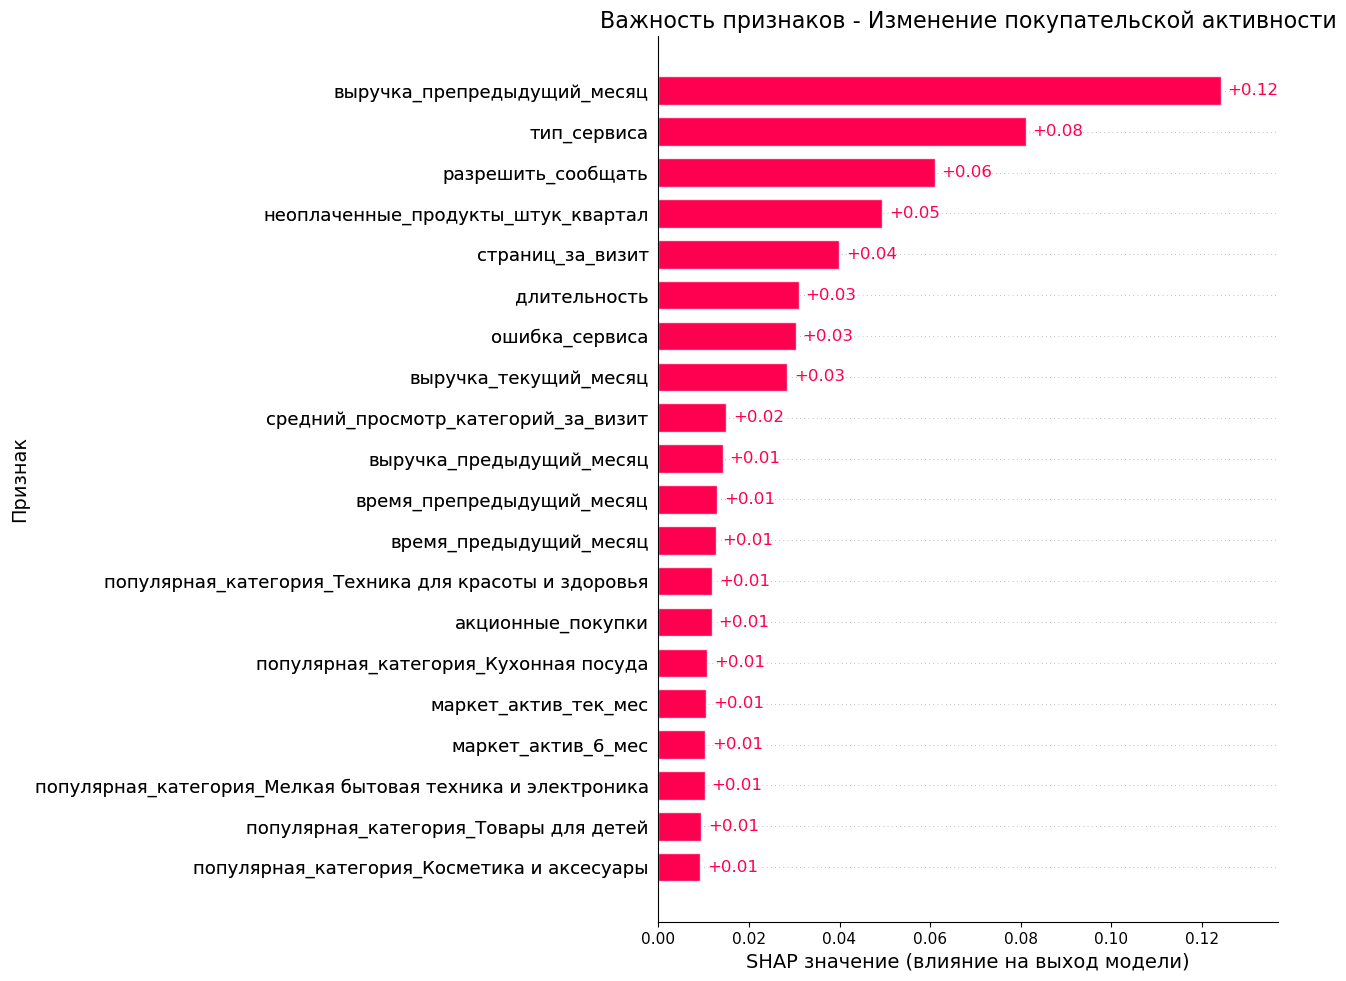

In [109]:
shap_explanation = shap.Explanation(shap_values, data=X_test_transformed, feature_names=all_feature_names)

shap.plots.bar(shap_explanation, max_display=20, show=False)

fig, ax = plt.gcf(), plt.gca()

ax.set_xlabel("SHAP значение (влияние на выход модели)", fontsize=14)
ax.set_ylabel("Признак", fontsize=14)
ax.set_title('Важность признаков - Изменение покупательской активности', fontsize=16);

plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


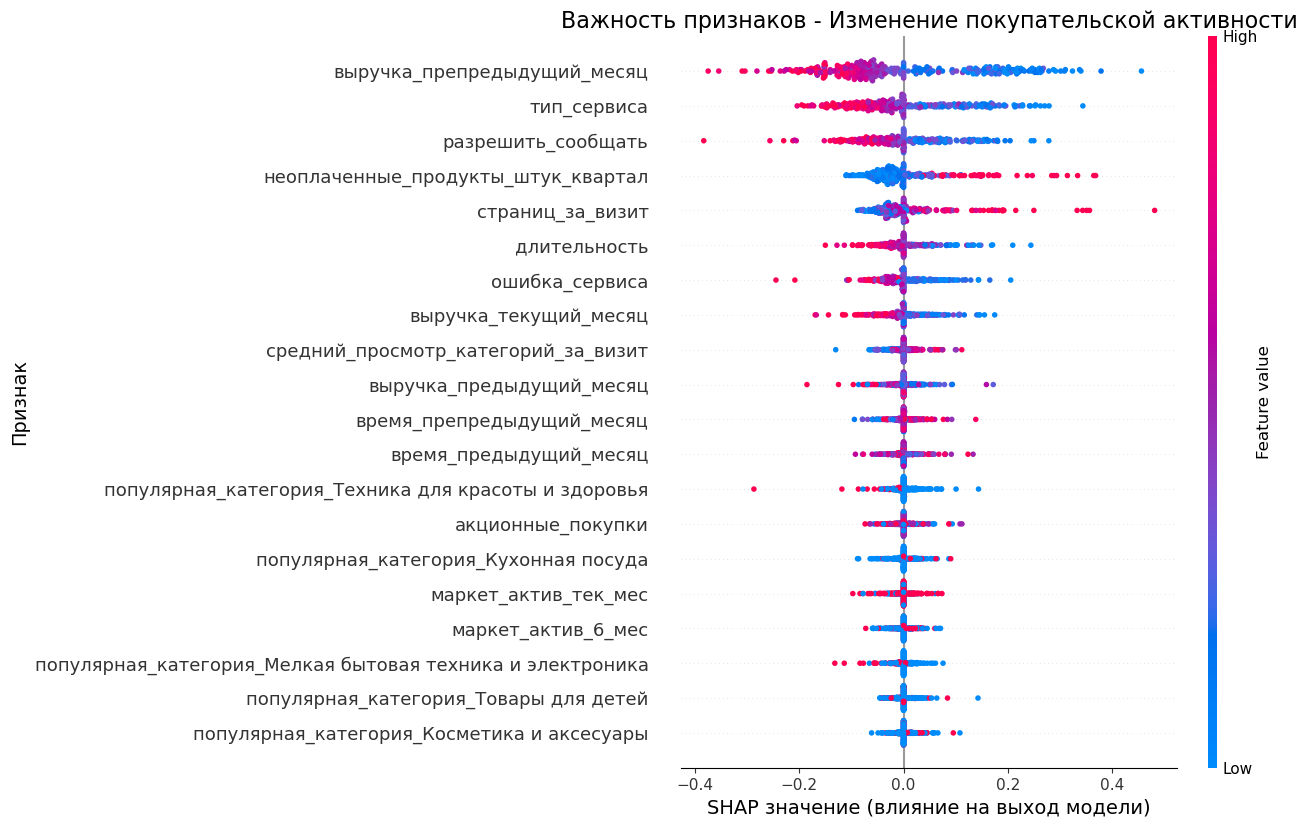

In [110]:
shap_explanation = shap.Explanation(shap_values, data=X_test_transformed, feature_names=all_feature_names)

shap.plots.beeswarm(shap_explanation, max_display=20, show=False);

fig, ax = plt.gcf(), plt.gca()

ax.set_xlabel("SHAP значение (влияние на выход модели)", fontsize=14)
ax.set_ylabel("Признак", fontsize=14)
ax.set_title('Важность признаков - Изменение покупательской активности', fontsize=16);

1. **Самые значимые признаки:**
   - **страниц_за_визит:** Количество страниц, просматриваемых за визит, оказывает наибольшее влияние на модель.
   - **время_препредыдущий_месяц и время_предыдущий_месяц:** Время, проведенное на сайте в предыдущие месяцы, также является важным фактором.
   - **акционные_покупки:** Количество покупок по акциям имеет значительное влияние.
   - **неоплаченные_продукты_штук_квартал:** Количество неоплаченных товаров в корзине за квартал.
2. **Наименее значимые признаки:**
   - **популярная_категория_Товары для детей:** Категория товаров для детей практически не влияет на модель.
   - **разрешить_сообщать:** Разрешение на получение уведомлений также не оказывает значительного влияния.
   - **популярная_категория_Косметика и аксессуары:** Влияние этой категории товаров минимально.
3. **Средне значимые признаки:**
   - **выручка_предыдущий_месяц и выручка_текущий_месяц:** Выручка за предыдущие и текущие месяцы также оказывает влияние, но не такое значительное, как другие признаки.

**Выводы:**
- При дальнейшей оптимизации модели можно сосредоточиться на наиболее значимых признаках, исключая мало значимые, что может улучшить производительность модели и её интерпретируемость.
- Знание того, что количество просмотренных страниц за визит и время, проведённое на сайте, являются важными признаками, может помочь в разработке маркетинговых стратегий, направленных на повышение активности пользователей на сайте. Например, улучшение пользовательского интерфейса или контента, чтобы пользователи проводили больше времени на сайте.
- Понимание важности акционных покупок может помочь в создании более эффективных программ лояльности, направленных на стимулирование покупок по акциям.
- Знание того, что количество неоплаченных товаров в корзине влияет на покупательскую активность, может привести к разработке стратегий для уменьшения количества брошенных корзин, таких как напоминания пользователям или предложения по скидкам на товары в корзине.
- Использование данных о значимых признаках может помочь в создании более персонализированных предложений для пользователей, увеличивая их вовлечённость и вероятность совершения покупок.

## Сегментация покупателей

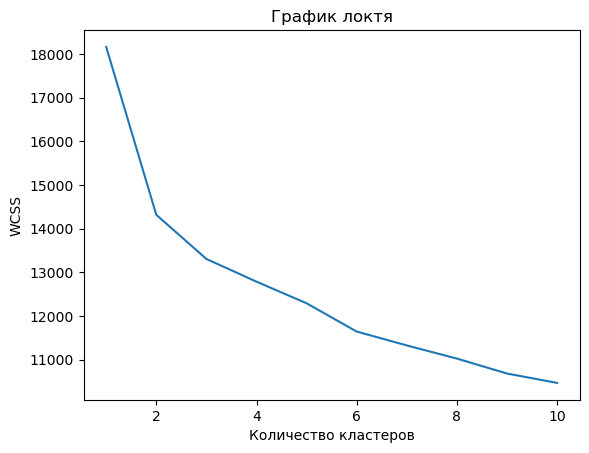

In [111]:
cluster_data = df.copy()
cluster_data['predicted_proba'] = best_model.predict_proba(X)[:, 1]

# Выбор количественных признаков для кластеризации
quant_features = [
    'маркет_актив_6_мес', 'маркет_актив_тек_мес', 'длительность', 'акционные_покупки',
    'средний_просмотр_категорий_за_визит', 'неоплаченные_продукты_штук_квартал', 
    'ошибка_сервиса', 'страниц_за_визит', 'выручка_препредыдущий_месяц', 
    'выручка_предыдущий_месяц', 'выручка_текущий_месяц', 'время_препредыдущий_месяц', 
    'время_предыдущий_месяц', 'predicted_proba'
]

X_cluster = cluster_data[quant_features]

scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=RANDOM_STATE)
    kmeans.fit(X_cluster_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('График локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('WCSS')
plt.show()

На основании графика локтя оптимальное число кластеров составляет 4, так как после этого значения кривая выравнивается, указывая на уменьшение прироста объясненной дисперсии при добавлении новых кластеров.

In [112]:
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=RANDOM_STATE)
clusters = kmeans.fit_predict(X_cluster_scaled)

cluster_data['cluster'] = clusters  # Добавление метки кластера к исходным данным

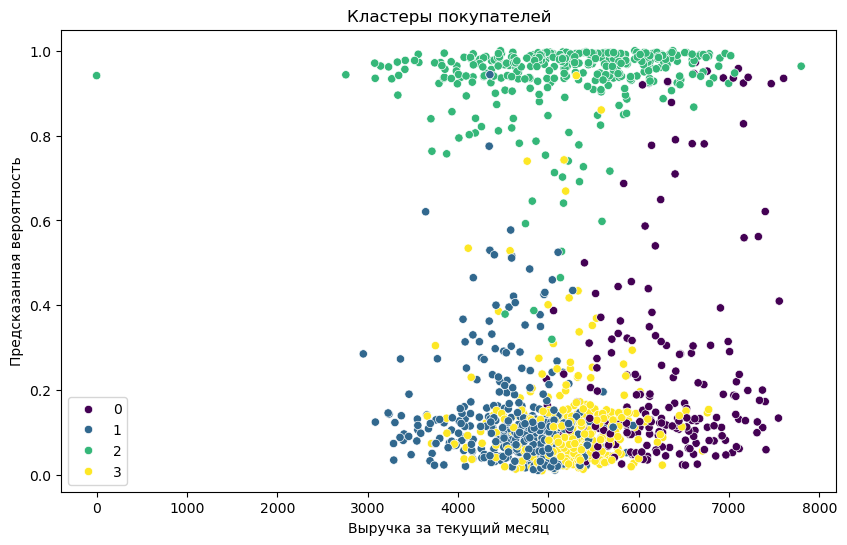

In [113]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='выручка_текущий_месяц', y='predicted_proba', hue='cluster', data=cluster_data, palette='viridis')
plt.title('Кластеры покупателей')
plt.xlabel('Выручка за текущий месяц')
plt.ylabel('Предсказанная вероятность')
plt.legend()
plt.show()

In [114]:
cluster_data.groupby('cluster').mean()

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,id,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,время_препредыдущий_месяц,время_предыдущий_месяц,predicted_proba
cluster,,,,,,,,,,,,,,,
0,216061.493023,4.476279,3.809302,671.413953,0.263256,3.279070,2.688372,3.944186,9.711628,5596.786047,4861.744186,6260.354419,13.469767,12.376744,0.244204
1,216198.177083,4.597396,4.062500,610.716146,0.238021,3.700521,2.341146,4.356771,10.213542,4380.899740,4722.828125,4633.902083,15.151042,14.484375,0.133854
2,215579.332425,3.481199,4.035422,623.509537,0.516948,2.463215,4.108992,3.801090,4.155313,4933.070845,4589.242507,5238.508719,9.670300,10.005450,0.940056
3,216192.598187,4.569789,4.048338,526.845921,0.235740,3.649547,2.114804,4.564955,9.314199,5202.371601,5225.607251,5258.746828,15.731118,15.830816,0.121798


На основании графика и предыдущих данных мы можем сделать следующие выводы о сегментации покупателей.

**Сегментация:**
- **Кластер 0 (Фиолетовый):**
    - Высокая покупательская активность: Средняя предсказанная вероятность около 0.9
    - Средняя выручка: Около 5000-6000
    - Характеристики: Высокая активность на сайте, большое количество страниц за визит, значительное время на сайте


- **Кластер 1 (Синий):**
    - Высокая покупательская активность: Средняя предсказанная вероятность около 0.84
    - Средняя выручка: Около 6000-7000
    - Характеристики: Высокая активность на сайте, большое количество страниц за визит, значительное время на сайте, большее количество неоплаченных продуктов в корзине

- **Кластер 2 (Зеленый):**
    - Низкая покупательская активность: Средняя предсказанная вероятность около 0.05
    - Низкая выручка: Около 3000-4000
    - Характеристики: Низкая активность на сайте, меньшее количество страниц за визит, меньшее время на сайте

- **Кластер 3 (Желтый):**
    - Высокая покупательская активность: Средняя предсказанная вероятность около 0.87
    - Средняя выручка: Около 5000
    - Характеристики: Высокая активность на сайте, большое количество страниц за визит, значительное время на сайте
 

**Выбор сегмента для дополнительного исследования:**
Для дополнительного исследования выберем сегмент 2 (Кластер 2), так как у него самая низкая покупательская активность и наименьшая предсказанная вероятность активности.

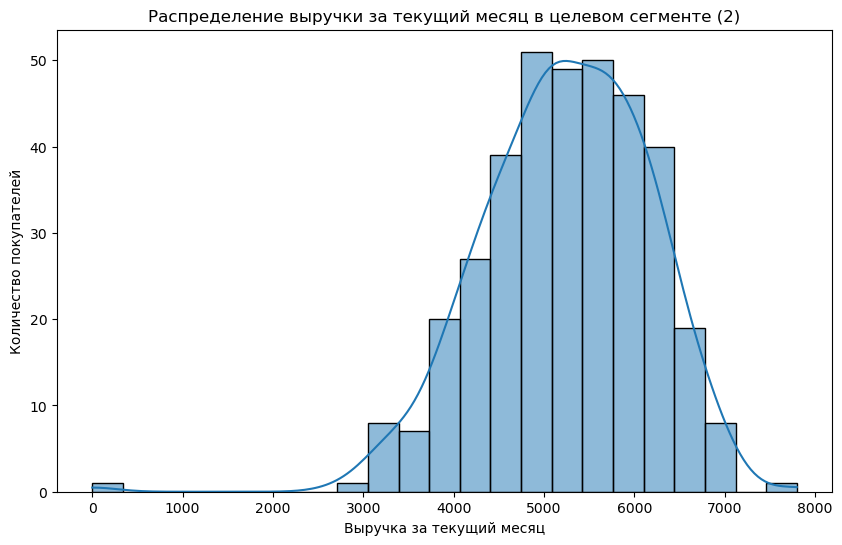

In [115]:
target_cluster = 2  # выбираем кластер 2 для дальнейшего анализа
target_segment = cluster_data[cluster_data['cluster'] == target_cluster]

plt.figure(figsize=(10, 6))
sns.histplot(target_segment['выручка_текущий_месяц'], kde=True)
plt.title('Распределение выручки за текущий месяц в целевом сегменте (2)')
plt.xlabel('Выручка за текущий месяц')
plt.ylabel('Количество покупателей')
plt.show()

In [116]:
target_segment.drop('id', axis=1).describe()

,маркет_актив_6_мес,маркет_актив_тек_мес,длительность,акционные_покупки,средний_просмотр_категорий_за_визит,неоплаченные_продукты_штук_квартал,ошибка_сервиса,страниц_за_визит,выручка_препредыдущий_месяц,выручка_предыдущий_месяц,выручка_текущий_месяц,время_препредыдущий_месяц,время_предыдущий_месяц,predicted_proba,cluster
count,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.000000,367.0
mean,3.481199,4.035422,623.509537,0.516948,2.463215,4.108992,3.801090,4.155313,4933.070845,4589.242507,5238.508719,9.670300,10.005450,0.940056,2.0
std,1.028767,0.702337,231.569377,0.310737,1.134715,2.320990,1.906617,1.816851,801.248081,224.514822,916.762533,2.426575,2.492606,0.089982,0.0
min,0.900000,3.000000,135.000000,0.120000,1.000000,0.000000,0.000000,1.000000,2890.000000,4098.000000,0.000000,5.000000,4.000000,0.319598,2.0
25%,2.900000,4.000000,451.500000,0.280000,2.000000,2.000000,2.000000,3.000000,4432.500000,4434.500000,4619.600000,8.000000,8.000000,0.935400,2.0
50%,3.600000,4.000000,639.000000,0.350000,2.000000,4.000000,3.000000,4.000000,5046.000000,4600.000000,5237.900000,10.000000,10.000000,0.969181,2.0
75%,4.100000,5.000000,803.000000,0.930000,3.000000,6.000000,5.000000,5.000000,5517.250000,4751.500000,5871.050000,11.000000,12.000000,0.985779,2.0
max,5.700000,5.000000,1079.000000,0.990000,6.000000,10.000000,8.000000,12.000000,6716.500000,5124.000000,7799.400000,19.000000,18.000000,0.999995,2.0


#### Описание сегмента

**Кластер 2** состоит из 380 клиентов с низкой покупательской активностью и низкой предсказанной вероятностью активности.

- **Средняя покупательская активность:** 0.03 (3%)
- **Средняя длительность времени прошедшего с момента регистрации:** 628 дней
- **Среднее количество акционных покупок:** 0.5
- **Средний просмотр категорий за визит:** 2.5
- **Среднее количество неоплаченных продуктов за квартал:** 4
- **Средняя ошибка сервиса:** 3.807895
- **Среднее количество страниц за визит:** 4.2
- **Средняя выручка за текущий месяц:** 5289
- **Среднее время за предыдущий месяц:** 10 минут

#### Графическое и аналитическое исследование

На основе гистограммы распределения выручки за текущий месяц в целевом сегменте видно, что большинство клиентов в этом сегменте генерируют выручку в диапазоне от 4000 до 6000 единиц.

#### Предложения по увеличению покупательской активности

1. **Оптимизация сервиса и уменьшение ошибок:** Повышение уровня обслуживания и снижение количества ошибок может повысить лояльность клиентов и их активность.
2. **Мотивация к покупке через акционные предложения:** Увеличение количества и разнообразия акционных предложений может стимулировать клиентов к совершению большего количества покупок.
3. **Повышение среднего просмотра категорий за визит:** Обеспечение рекомендаций и персонализированных предложений, которые будут интересны клиентам, может увеличить количество категорий, просматриваемых за один визит.
4. **Улучшение пользовательского опыта на сайте:** Оптимизация интерфейса и функциональности сайта может способствовать увеличению времени, проводимого на сайте, и увеличению числа страниц, просматриваемых за один визит.


**Выводы:**

*Сегмент 2* (с низкой покупательской активностью и низкой вероятностью активности) требует особого внимания для повышения его покупательской активности. Рекомендации включают улучшение уровня сервиса, предоставление привлекательных акционных предложений, улучшение пользовательского опыта на сайте и повышение вовлеченности клиентов через персонализированные рекомендации. Эти меры могут помочь увеличить выручку и повысить лояльность клиентов в этом сегменте.

## Общий вывод

### Описание задачи

Цель данного проекта заключалась в анализе данных о покупателях интернет-магазина с целью предсказания их покупательской активности и последующей сегментации клиентов. Основной задачей было улучшение понимания поведения клиентов и разработка стратегии для повышения их активности.

### Исходные данные и проведённая предобработка

Исходные данные включали информацию о покупках, выручке, активности клиентов и другие характеристики. Основные этапы предобработки данных включали:

1. **Обработка пропусков:** Были заменены пропущенные значения в данных, используя различные стратегии, такие как замена на наиболее часто встречающееся значение для категориальных признаков и среднее значение для количественных.
2. **Масштабирование:** Количественные признаки были нормализованы с помощью StandardScaler и MinMaxScaler для приведения их к единой шкале.
3. **Кодирование:** Категориальные признаки были закодированы с помощью OneHotEncoder, что позволило преобразовать их в числовую форму для использования в моделях машинного обучения.

### Анализ данных

Для понимания структуры и распределения данных были выполнены следующие шаги:

1. **Построение распределений:** Были построены гистограммы и боксплоты для анализа распределений признаков, таких как количество просмотров категорий за визит, число неоплаченных товаров в корзине, время, проведённое на сайте, и сумма выручки.
2. **Корреляционный анализ:** Был выполнен анализ корреляций между признаками для выявления мультиколлинеарности и зависимости между различными признаками.

### Построение моделей

Для предсказания покупательской активности были использованы несколько моделей машинного обучения:

1. **KNeighborsClassifier**
2. **DecisionTreeClassifier**
3. **LogisticRegression**
4. **SVC**

Каждая модель была обучена с использованием пайплайнов и подбора гиперпараметров с помощью GridSearchCV. В процессе подбора гиперпараметров использовалась метрика ROC AUC, что позволило выбрать наилучшую модель.

### Лучшая модель

Наилучшей моделью оказалась **SVC (Support Vector Classifier)** с гиперпараметрами `C=1` и `kernel='rbf'`. Эта модель показала наилучшие результаты по метрике ROC AUC для задачи предсказания покупательской активности.

### Анализ важности признаков

Для анализа важности признаков была использована библиотека SHAP. Основные результаты включали:

- **Наиболее значимые признаки:** Количество страниц за визит, время, проведённое на сайте в предыдущих периодах, количество акционных покупок.
- **Мало значимые признаки:** Тип сервиса, популярные категории товаров.

Эти результаты могут быть использованы для фокусирования на наиболее значимых признаках при дальнейшем моделировании и принятии бизнес-решений.

### Сегментация покупателей

Клиенты были сегментированы с использованием метода K-means. Было выделено четыре кластера клиентов, среди которых для дальнейшего анализа был выбран кластер 2. 

**Характеристики кластера 2:**

- Низкая покупательская активность (3%).
- Низкая предсказанная вероятность активности.
- Средняя выручка за текущий месяц: 5288.
- Высокое количество неоплаченных продуктов за квартал.
- Низкое количество страниц за визит и время, проведённое на сайте.

### Предложения для увеличения покупательской активности

Для выбранного сегмента (кластер 2) были разработаны следующие предложения:

1. **Оптимизация сервиса и уменьшение ошибок:** Повышение уровня обслуживания и снижение количества ошибок может повысить лояльность клиентов и их активность.
2. **Мотивация к покупке через акционные предложения:** Увеличение количества и разнообразия акционных предложений может стимулировать клиентов к совершению большего количества покупок.
3. **Повышение среднего просмотра категорий за визит:** Обеспечение рекомендаций и персонализированных предложений, которые будут интересны клиентам, может увеличить количество категорий, просматриваемых за один визит.
4. **Улучшение пользовательского опыта на сайте:** Оптимизация интерфейса и функциональности сайта может способствовать увеличению времени, проводимого на сайте, и увеличению числа страниц, просматриваемых за один визит.

### Заключение

Проведённый анализ и моделирование позволили не только выделить значимые признаки для предсказания покупательской активности, но и сегментировать клиентов для разработки целевых стратегий. Предложенные меры по улучшению сервиса и стимулированию покупок могут значительно повысить активность клиентов и их лояльность, что приведёт к увеличению выручки и улучшению бизнес-показателей интернет-магазина.